In [4]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torchvision.utils as vutils
from random import randint

In [57]:
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),])

train_dataset = datasets.ImageFolder(root=r'traingrey',transform=data_transform)
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=4)



In [58]:
def show_batch_images(sample_batch):
    labels_batch = sample_batch[1]
    images_batch = sample_batch[0]
    batchsz=len(images_batch)

    for i in range(batchsz):
        label_ = labels_batch[i].item()
        image_ = np.transpose(images_batch[i], (1,2,0))
        ax = plt.subplot(1, batchsz, i + 1)
        ax.imshow(image_)
        # ax.set_title(str(label_))
        ax.axis('off')

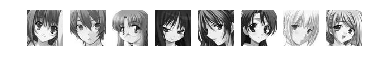

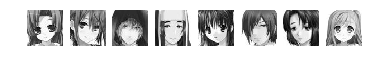

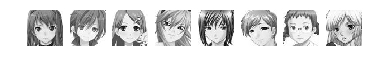

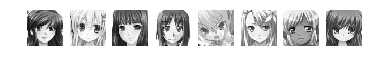

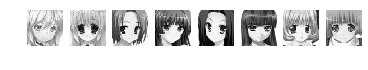

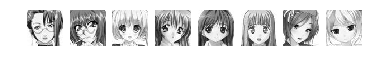

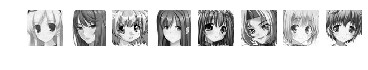

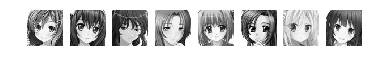

In [59]:
plt.figure()
k=1
for i_batch, sample_batch in enumerate(train_dataloader):
    show_batch_images(sample_batch)
    
    plt.show()
    k=k+1
    if k==9:
        break

In [2]:
# 定义生成器网络G
class NetG(nn.Module):
    def __init__(self, ngf, nz):
        super(NetG, self).__init__()
        # layer1输入的是一个100x1x1的随机噪声, 输出尺寸(ngf*8)x4x4
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True)
        )
        # layer2输出尺寸(ngf*4)x8x8
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True)
        )
        # layer3输出尺寸(ngf*2)x16x16
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True)
        )
        # layer4输出尺寸(ngf)x32x32
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True)
        )
        # layer5输出尺寸 3x96x96
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, 3, 5, 3, 1, bias=False),
            nn.Tanh()
        )

    # 定义NetG的前向传播
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

In [3]:
# 定义鉴别器网络D
class NetD(nn.Module):
    def __init__(self, ndf):
        super(NetD, self).__init__()
        # layer1 输入 3 x 96 x 96, 输出 (ndf) x 32 x 32
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, ndf, kernel_size=5, stride=3, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # layer2 输出 (ndf*2) x 16 x 16
        self.layer2 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # layer3 输出 (ndf*4) x 8 x 8
        self.layer3 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # layer4 输出 (ndf*8) x 4 x 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # layer5 输出一个数(概率)
        self.layer5 = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    # 定义NetD的前向传播
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

In [8]:
batchSize=64
imageSize=96
nz=100
ngf=64
ndf=64
epoch=25
lr=0.0002
beta1=0.5
data_path='train/'
outf='imgs/'


In [9]:
# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像读入与预处理
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Scale(imageSize),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])

dataset = torchvision.datasets.ImageFolder(data_path, transform=transforms)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batchSize,
    shuffle=True,
    drop_last=True,
)

netG = NetG(ngf, nz).to(device)
netD = NetD(ndf).to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

for epoch in range(1, epoch + 1):
    for i, (imgs,_) in enumerate(dataloader):
        # 固定生成器G，训练鉴别器D
        optimizerD.zero_grad()
        ## 让D尽可能的把真图片判别为1
        imgs=imgs.to(device)
        output = netD(imgs)
        label.data.fill_(real_label)
        label=label.to(device)
        errD_real = criterion(output, label)
        errD_real.backward()
        ## 让D尽可能把假图片判别为0
        label.data.fill_(fake_label)
        noise = torch.randn(batchSize, nz, 1, 1)
        noise=noise.to(device)
        fake = netG(noise)  # 生成假图
        output = netD(fake.detach()) #避免梯度传到G，因为G不用更新
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_fake + errD_real
        optimizerD.step()

        # 固定鉴别器D，训练生成器G
        optimizerG.zero_grad()
        # 让D尽可能把G生成的假图判别为1
        label.data.fill_(real_label)
        label = label.to(device)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.3f Loss_G %.3f'
              % (epoch, epoch, i, len(dataloader), errD.item(), errG.item()))

    vutils.save_image(fake.data,
                      '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                      normalize=True)
    torch.save(netG.state_dict(), '%s/netG_%03d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_%03d.pth' % (outf, epoch))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/1][0/894] Loss_D: 1.512 Loss_G 2.249
[1/1][1/894] Loss_D: 0.982 Loss_G 3.515
[1/1][2/894] Loss_D: 0.354 Loss_G 4.485
[1/1][3/894] Loss_D: 0.220 Loss_G 4.599
[1/1][4/894] Loss_D: 0.208 Loss_G 4.789
[1/1][5/894] Loss_D: 0.255 Loss_G 5.277
[1/1][6/894] Loss_D: 0.189 Loss_G 5.540
[1/1][7/894] Loss_D: 0.167 Loss_G 5.718
[1/1][8/894] Loss_D: 0.176 Loss_G 6.421
[1/1][9/894] Loss_D: 0.095 Loss_G 6.519
[1/1][10/894] Loss_D: 0.163 Loss_G 6.532
[1/1][11/894] Loss_D: 0.098 Loss_G 6.798
[1/1][12/894] Loss_D: 0.072 Loss_G 6.854
[1/1][13/894] Loss_D: 0.117 Loss_G 6.516
[1/1][14/894] Loss_D: 0.107 Loss_G 7.867
[1/1][15/894] Loss_D: 0.111 Loss_G 7.001
[1/1][16/894] Loss_D: 0.090 Loss_G 7.649
[1/1][17/894] Loss_D: 0.049 Loss_G 7.695
[1/1][18/894] Loss_D: 0.062 Loss_G 7.319
[1/1][19/894] Loss_D: 0.091 Loss_G 8.247
[1/1][20/894] Loss_D: 0.044 Loss_G 7.519
[1/1][21/894] Loss_D: 0.100 Loss_G 7.487
[1/1][22/894] Loss_D: 0.063 Loss_G 7.786
[1/1][23/894] Loss_D: 0.043 Loss_G 8.053
[1/1][24/894] Loss_D: 0.06

[1/1][197/894] Loss_D: 0.066 Loss_G 6.487
[1/1][198/894] Loss_D: 0.066 Loss_G 6.217
[1/1][199/894] Loss_D: 0.049 Loss_G 6.664
[1/1][200/894] Loss_D: 0.051 Loss_G 6.507
[1/1][201/894] Loss_D: 0.080 Loss_G 6.401
[1/1][202/894] Loss_D: 0.057 Loss_G 6.582
[1/1][203/894] Loss_D: 0.032 Loss_G 6.826
[1/1][204/894] Loss_D: 0.047 Loss_G 6.543
[1/1][205/894] Loss_D: 0.057 Loss_G 6.471
[1/1][206/894] Loss_D: 0.050 Loss_G 6.711
[1/1][207/894] Loss_D: 0.032 Loss_G 6.815
[1/1][208/894] Loss_D: 0.073 Loss_G 6.539
[1/1][209/894] Loss_D: 0.048 Loss_G 7.566
[1/1][210/894] Loss_D: 0.025 Loss_G 7.248
[1/1][211/894] Loss_D: 0.051 Loss_G 6.408
[1/1][212/894] Loss_D: 0.044 Loss_G 6.897
[1/1][213/894] Loss_D: 0.050 Loss_G 6.694
[1/1][214/894] Loss_D: 0.041 Loss_G 6.543
[1/1][215/894] Loss_D: 0.046 Loss_G 6.655
[1/1][216/894] Loss_D: 0.056 Loss_G 6.875
[1/1][217/894] Loss_D: 0.038 Loss_G 7.112
[1/1][218/894] Loss_D: 0.043 Loss_G 6.857
[1/1][219/894] Loss_D: 0.079 Loss_G 6.474
[1/1][220/894] Loss_D: 0.034 Loss_

[1/1][393/894] Loss_D: 0.022 Loss_G 9.950
[1/1][394/894] Loss_D: 0.006 Loss_G 10.227
[1/1][395/894] Loss_D: 0.029 Loss_G 7.712
[1/1][396/894] Loss_D: 0.026 Loss_G 4.195
[1/1][397/894] Loss_D: 0.240 Loss_G 25.970
[1/1][398/894] Loss_D: 17.369 Loss_G 16.081
[1/1][399/894] Loss_D: 1.030 Loss_G 7.771
[1/1][400/894] Loss_D: 0.008 Loss_G 2.727
[1/1][401/894] Loss_D: 0.773 Loss_G 13.991
[1/1][402/894] Loss_D: 0.504 Loss_G 14.475
[1/1][403/894] Loss_D: 0.184 Loss_G 12.907
[1/1][404/894] Loss_D: 0.048 Loss_G 8.932
[1/1][405/894] Loss_D: 1.328 Loss_G 16.643
[1/1][406/894] Loss_D: 1.989 Loss_G 14.599
[1/1][407/894] Loss_D: 0.544 Loss_G 8.966
[1/1][408/894] Loss_D: 0.564 Loss_G 6.923
[1/1][409/894] Loss_D: 0.240 Loss_G 9.391
[1/1][410/894] Loss_D: 0.040 Loss_G 9.533
[1/1][411/894] Loss_D: 0.184 Loss_G 7.182
[1/1][412/894] Loss_D: 0.082 Loss_G 5.273
[1/1][413/894] Loss_D: 0.538 Loss_G 15.199
[1/1][414/894] Loss_D: 1.431 Loss_G 12.025
[1/1][415/894] Loss_D: 0.055 Loss_G 9.072
[1/1][416/894] Loss_D: 

[1/1][588/894] Loss_D: 0.035 Loss_G 7.069
[1/1][589/894] Loss_D: 0.029 Loss_G 7.003
[1/1][590/894] Loss_D: 0.052 Loss_G 6.389
[1/1][591/894] Loss_D: 0.033 Loss_G 6.593
[1/1][592/894] Loss_D: 0.028 Loss_G 6.759
[1/1][593/894] Loss_D: 0.035 Loss_G 6.841
[1/1][594/894] Loss_D: 0.038 Loss_G 6.593
[1/1][595/894] Loss_D: 0.052 Loss_G 8.133
[1/1][596/894] Loss_D: 0.013 Loss_G 7.653
[1/1][597/894] Loss_D: 0.023 Loss_G 6.760
[1/1][598/894] Loss_D: 0.054 Loss_G 6.873
[1/1][599/894] Loss_D: 0.017 Loss_G 7.074
[1/1][600/894] Loss_D: 0.031 Loss_G 6.521
[1/1][601/894] Loss_D: 0.022 Loss_G 6.543
[1/1][602/894] Loss_D: 0.014 Loss_G 6.807
[1/1][603/894] Loss_D: 0.036 Loss_G 6.868
[1/1][604/894] Loss_D: 0.039 Loss_G 7.026
[1/1][605/894] Loss_D: 0.017 Loss_G 6.995
[1/1][606/894] Loss_D: 0.017 Loss_G 6.762
[1/1][607/894] Loss_D: 0.019 Loss_G 6.502
[1/1][608/894] Loss_D: 0.018 Loss_G 6.453
[1/1][609/894] Loss_D: 0.021 Loss_G 6.496
[1/1][610/894] Loss_D: 0.090 Loss_G 8.627
[1/1][611/894] Loss_D: 0.020 Loss_

[1/1][784/894] Loss_D: 0.005 Loss_G 6.842
[1/1][785/894] Loss_D: 0.005 Loss_G 6.832
[1/1][786/894] Loss_D: 0.004 Loss_G 6.900
[1/1][787/894] Loss_D: 0.003 Loss_G 7.187
[1/1][788/894] Loss_D: 0.011 Loss_G 6.407
[1/1][789/894] Loss_D: 0.006 Loss_G 6.477
[1/1][790/894] Loss_D: 0.007 Loss_G 6.491
[1/1][791/894] Loss_D: 0.006 Loss_G 6.677
[1/1][792/894] Loss_D: 0.003 Loss_G 7.116
[1/1][793/894] Loss_D: 0.004 Loss_G 6.832
[1/1][794/894] Loss_D: 0.006 Loss_G 6.662
[1/1][795/894] Loss_D: 0.005 Loss_G 6.835
[1/1][796/894] Loss_D: 0.004 Loss_G 7.277
[1/1][797/894] Loss_D: 0.003 Loss_G 7.124
[1/1][798/894] Loss_D: 0.016 Loss_G 6.067
[1/1][799/894] Loss_D: 0.006 Loss_G 6.020
[1/1][800/894] Loss_D: 0.009 Loss_G 6.739
[1/1][801/894] Loss_D: 0.003 Loss_G 7.464
[1/1][802/894] Loss_D: 0.004 Loss_G 7.403
[1/1][803/894] Loss_D: 0.004 Loss_G 7.046
[1/1][804/894] Loss_D: 0.008 Loss_G 6.350
[1/1][805/894] Loss_D: 0.004 Loss_G 6.488
[1/1][806/894] Loss_D: 0.004 Loss_G 6.796
[1/1][807/894] Loss_D: 0.005 Loss_

[2/2][88/894] Loss_D: 0.002 Loss_G 7.083
[2/2][89/894] Loss_D: 0.003 Loss_G 6.919
[2/2][90/894] Loss_D: 0.004 Loss_G 7.041
[2/2][91/894] Loss_D: 0.002 Loss_G 7.189
[2/2][92/894] Loss_D: 0.002 Loss_G 7.560
[2/2][93/894] Loss_D: 0.002 Loss_G 7.329
[2/2][94/894] Loss_D: 0.002 Loss_G 7.120
[2/2][95/894] Loss_D: 0.003 Loss_G 6.932
[2/2][96/894] Loss_D: 0.002 Loss_G 7.362
[2/2][97/894] Loss_D: 0.001 Loss_G 7.964
[2/2][98/894] Loss_D: 0.006 Loss_G 7.905
[2/2][99/894] Loss_D: 0.004 Loss_G 6.956
[2/2][100/894] Loss_D: 0.004 Loss_G 6.776
[2/2][101/894] Loss_D: 0.003 Loss_G 7.225
[2/2][102/894] Loss_D: 0.002 Loss_G 7.630
[2/2][103/894] Loss_D: 0.001 Loss_G 7.735
[2/2][104/894] Loss_D: 0.002 Loss_G 7.552
[2/2][105/894] Loss_D: 0.003 Loss_G 7.201
[2/2][106/894] Loss_D: 0.002 Loss_G 7.232
[2/2][107/894] Loss_D: 0.003 Loss_G 7.250
[2/2][108/894] Loss_D: 0.004 Loss_G 7.508
[2/2][109/894] Loss_D: 0.002 Loss_G 7.631
[2/2][110/894] Loss_D: 0.002 Loss_G 7.629
[2/2][111/894] Loss_D: 0.003 Loss_G 7.143
[2/2

[2/2][284/894] Loss_D: 0.001 Loss_G 8.375
[2/2][285/894] Loss_D: 0.002 Loss_G 7.323
[2/2][286/894] Loss_D: 0.003 Loss_G 7.259
[2/2][287/894] Loss_D: 0.003 Loss_G 7.334
[2/2][288/894] Loss_D: 0.003 Loss_G 7.525
[2/2][289/894] Loss_D: 0.002 Loss_G 7.790
[2/2][290/894] Loss_D: 0.002 Loss_G 8.340
[2/2][291/894] Loss_D: 0.004 Loss_G 8.668
[2/2][292/894] Loss_D: 0.003 Loss_G 7.591
[2/2][293/894] Loss_D: 0.003 Loss_G 6.928
[2/2][294/894] Loss_D: 0.005 Loss_G 7.711
[2/2][295/894] Loss_D: 0.004 Loss_G 8.003
[2/2][296/894] Loss_D: 0.006 Loss_G 7.611
[2/2][297/894] Loss_D: 0.002 Loss_G 7.220
[2/2][298/894] Loss_D: 0.002 Loss_G 7.212
[2/2][299/894] Loss_D: 0.001 Loss_G 7.395
[2/2][300/894] Loss_D: 0.004 Loss_G 7.215
[2/2][301/894] Loss_D: 0.003 Loss_G 7.222
[2/2][302/894] Loss_D: 0.004 Loss_G 7.305
[2/2][303/894] Loss_D: 0.001 Loss_G 7.777
[2/2][304/894] Loss_D: 0.007 Loss_G 6.998
[2/2][305/894] Loss_D: 0.003 Loss_G 7.056
[2/2][306/894] Loss_D: 0.003 Loss_G 7.524
[2/2][307/894] Loss_D: 0.002 Loss_

[2/2][479/894] Loss_D: 0.056 Loss_G 6.326
[2/2][480/894] Loss_D: 0.061 Loss_G 5.550
[2/2][481/894] Loss_D: 0.054 Loss_G 4.986
[2/2][482/894] Loss_D: 0.084 Loss_G 4.918
[2/2][483/894] Loss_D: 0.082 Loss_G 4.908
[2/2][484/894] Loss_D: 0.090 Loss_G 4.643
[2/2][485/894] Loss_D: 0.065 Loss_G 4.976
[2/2][486/894] Loss_D: 0.076 Loss_G 4.906
[2/2][487/894] Loss_D: 0.113 Loss_G 4.358
[2/2][488/894] Loss_D: 0.120 Loss_G 4.785
[2/2][489/894] Loss_D: 0.114 Loss_G 4.868
[2/2][490/894] Loss_D: 0.063 Loss_G 5.214
[2/2][491/894] Loss_D: 0.067 Loss_G 5.090
[2/2][492/894] Loss_D: 0.074 Loss_G 4.937
[2/2][493/894] Loss_D: 0.151 Loss_G 4.067
[2/2][494/894] Loss_D: 0.079 Loss_G 5.635
[2/2][495/894] Loss_D: 0.045 Loss_G 5.789
[2/2][496/894] Loss_D: 0.091 Loss_G 5.064
[2/2][497/894] Loss_D: 0.035 Loss_G 4.722
[2/2][498/894] Loss_D: 0.056 Loss_G 4.838
[2/2][499/894] Loss_D: 0.073 Loss_G 4.681
[2/2][500/894] Loss_D: 0.066 Loss_G 4.778
[2/2][501/894] Loss_D: 0.045 Loss_G 5.187
[2/2][502/894] Loss_D: 0.044 Loss_

[2/2][674/894] Loss_D: 0.185 Loss_G 4.267
[2/2][675/894] Loss_D: 0.278 Loss_G 8.544
[2/2][676/894] Loss_D: 0.468 Loss_G 4.416
[2/2][677/894] Loss_D: 0.606 Loss_G 11.550
[2/2][678/894] Loss_D: 1.407 Loss_G 6.765
[2/2][679/894] Loss_D: 0.038 Loss_G 2.072
[2/2][680/894] Loss_D: 1.133 Loss_G 10.839
[2/2][681/894] Loss_D: 0.177 Loss_G 11.967
[2/2][682/894] Loss_D: 0.249 Loss_G 10.036
[2/2][683/894] Loss_D: 0.054 Loss_G 8.125
[2/2][684/894] Loss_D: 0.040 Loss_G 5.394
[2/2][685/894] Loss_D: 0.211 Loss_G 5.778
[2/2][686/894] Loss_D: 0.071 Loss_G 6.435
[2/2][687/894] Loss_D: 0.150 Loss_G 6.907
[2/2][688/894] Loss_D: 0.127 Loss_G 5.768
[2/2][689/894] Loss_D: 0.210 Loss_G 6.289
[2/2][690/894] Loss_D: 0.130 Loss_G 6.495
[2/2][691/894] Loss_D: 0.151 Loss_G 8.370
[2/2][692/894] Loss_D: 0.217 Loss_G 5.141
[2/2][693/894] Loss_D: 0.377 Loss_G 11.549
[2/2][694/894] Loss_D: 1.081 Loss_G 3.660
[2/2][695/894] Loss_D: 0.623 Loss_G 10.908
[2/2][696/894] Loss_D: 0.319 Loss_G 10.137
[2/2][697/894] Loss_D: 0.19

[2/2][869/894] Loss_D: 0.333 Loss_G 4.768
[2/2][870/894] Loss_D: 0.242 Loss_G 5.244
[2/2][871/894] Loss_D: 0.226 Loss_G 4.310
[2/2][872/894] Loss_D: 0.343 Loss_G 3.603
[2/2][873/894] Loss_D: 0.319 Loss_G 5.876
[2/2][874/894] Loss_D: 0.248 Loss_G 4.246
[2/2][875/894] Loss_D: 0.212 Loss_G 5.386
[2/2][876/894] Loss_D: 0.106 Loss_G 6.453
[2/2][877/894] Loss_D: 0.211 Loss_G 4.187
[2/2][878/894] Loss_D: 0.224 Loss_G 6.853
[2/2][879/894] Loss_D: 0.169 Loss_G 4.876
[2/2][880/894] Loss_D: 0.200 Loss_G 6.313
[2/2][881/894] Loss_D: 0.205 Loss_G 3.202
[2/2][882/894] Loss_D: 0.415 Loss_G 13.882
[2/2][883/894] Loss_D: 4.699 Loss_G 0.204
[2/2][884/894] Loss_D: 3.285 Loss_G 9.234
[2/2][885/894] Loss_D: 1.171 Loss_G 6.950
[2/2][886/894] Loss_D: 0.170 Loss_G 4.464
[2/2][887/894] Loss_D: 0.093 Loss_G 3.245
[2/2][888/894] Loss_D: 0.173 Loss_G 3.319
[2/2][889/894] Loss_D: 0.228 Loss_G 4.071
[2/2][890/894] Loss_D: 0.103 Loss_G 4.378
[2/2][891/894] Loss_D: 0.154 Loss_G 3.893
[2/2][892/894] Loss_D: 0.195 Loss

[3/3][173/894] Loss_D: 0.008 Loss_G 9.818
[3/3][174/894] Loss_D: 0.013 Loss_G 6.210
[3/3][175/894] Loss_D: 0.079 Loss_G 5.326
[3/3][176/894] Loss_D: 0.279 Loss_G 9.082
[3/3][177/894] Loss_D: 0.203 Loss_G 7.623
[3/3][178/894] Loss_D: 0.234 Loss_G 3.222
[3/3][179/894] Loss_D: 0.710 Loss_G 10.833
[3/3][180/894] Loss_D: 2.236 Loss_G 3.141
[3/3][181/894] Loss_D: 0.464 Loss_G 7.590
[3/3][182/894] Loss_D: 0.063 Loss_G 7.819
[3/3][183/894] Loss_D: 0.198 Loss_G 4.480
[3/3][184/894] Loss_D: 0.218 Loss_G 4.897
[3/3][185/894] Loss_D: 0.178 Loss_G 5.717
[3/3][186/894] Loss_D: 0.111 Loss_G 4.929
[3/3][187/894] Loss_D: 0.299 Loss_G 4.330
[3/3][188/894] Loss_D: 0.245 Loss_G 6.319
[3/3][189/894] Loss_D: 0.314 Loss_G 3.113
[3/3][190/894] Loss_D: 0.742 Loss_G 11.832
[3/3][191/894] Loss_D: 2.730 Loss_G 3.572
[3/3][192/894] Loss_D: 0.279 Loss_G 4.332
[3/3][193/894] Loss_D: 0.162 Loss_G 6.203
[3/3][194/894] Loss_D: 0.141 Loss_G 4.828
[3/3][195/894] Loss_D: 0.172 Loss_G 3.798
[3/3][196/894] Loss_D: 0.392 Los

[3/3][368/894] Loss_D: 0.324 Loss_G 5.710
[3/3][369/894] Loss_D: 0.274 Loss_G 4.168
[3/3][370/894] Loss_D: 0.249 Loss_G 6.298
[3/3][371/894] Loss_D: 0.613 Loss_G 1.143
[3/3][372/894] Loss_D: 1.651 Loss_G 13.988
[3/3][373/894] Loss_D: 2.959 Loss_G 9.610
[3/3][374/894] Loss_D: 0.055 Loss_G 6.412
[3/3][375/894] Loss_D: 0.027 Loss_G 3.578
[3/3][376/894] Loss_D: 0.569 Loss_G 6.856
[3/3][377/894] Loss_D: 0.087 Loss_G 7.481
[3/3][378/894] Loss_D: 0.247 Loss_G 4.720
[3/3][379/894] Loss_D: 0.146 Loss_G 3.256
[3/3][380/894] Loss_D: 0.472 Loss_G 7.100
[3/3][381/894] Loss_D: 0.428 Loss_G 4.813
[3/3][382/894] Loss_D: 0.160 Loss_G 4.030
[3/3][383/894] Loss_D: 0.246 Loss_G 6.168
[3/3][384/894] Loss_D: 0.197 Loss_G 4.941
[3/3][385/894] Loss_D: 0.263 Loss_G 4.026
[3/3][386/894] Loss_D: 0.391 Loss_G 7.693
[3/3][387/894] Loss_D: 0.659 Loss_G 3.755
[3/3][388/894] Loss_D: 0.292 Loss_G 5.918
[3/3][389/894] Loss_D: 0.073 Loss_G 6.247
[3/3][390/894] Loss_D: 0.071 Loss_G 5.477
[3/3][391/894] Loss_D: 0.176 Loss

[3/3][563/894] Loss_D: 0.590 Loss_G 9.371
[3/3][564/894] Loss_D: 0.668 Loss_G 5.107
[3/3][565/894] Loss_D: 0.291 Loss_G 6.314
[3/3][566/894] Loss_D: 0.112 Loss_G 7.033
[3/3][567/894] Loss_D: 0.143 Loss_G 5.432
[3/3][568/894] Loss_D: 0.355 Loss_G 7.749
[3/3][569/894] Loss_D: 0.705 Loss_G 2.679
[3/3][570/894] Loss_D: 1.543 Loss_G 14.955
[3/3][571/894] Loss_D: 3.621 Loss_G 9.393
[3/3][572/894] Loss_D: 0.097 Loss_G 5.125
[3/3][573/894] Loss_D: 0.200 Loss_G 3.999
[3/3][574/894] Loss_D: 0.510 Loss_G 7.077
[3/3][575/894] Loss_D: 0.189 Loss_G 6.266
[3/3][576/894] Loss_D: 0.274 Loss_G 3.885
[3/3][577/894] Loss_D: 0.605 Loss_G 8.063
[3/3][578/894] Loss_D: 0.787 Loss_G 4.486
[3/3][579/894] Loss_D: 0.486 Loss_G 7.121
[3/3][580/894] Loss_D: 0.085 Loss_G 7.029
[3/3][581/894] Loss_D: 0.206 Loss_G 5.165
[3/3][582/894] Loss_D: 0.328 Loss_G 6.968
[3/3][583/894] Loss_D: 0.355 Loss_G 5.546
[3/3][584/894] Loss_D: 0.301 Loss_G 6.910
[3/3][585/894] Loss_D: 0.241 Loss_G 5.477
[3/3][586/894] Loss_D: 0.536 Loss

[3/3][758/894] Loss_D: 0.385 Loss_G 6.071
[3/3][759/894] Loss_D: 0.176 Loss_G 3.916
[3/3][760/894] Loss_D: 0.630 Loss_G 9.130
[3/3][761/894] Loss_D: 0.455 Loss_G 7.013
[3/3][762/894] Loss_D: 0.143 Loss_G 4.345
[3/3][763/894] Loss_D: 0.491 Loss_G 8.264
[3/3][764/894] Loss_D: 0.260 Loss_G 6.557
[3/3][765/894] Loss_D: 0.141 Loss_G 4.229
[3/3][766/894] Loss_D: 0.491 Loss_G 8.267
[3/3][767/894] Loss_D: 0.483 Loss_G 5.543
[3/3][768/894] Loss_D: 0.142 Loss_G 3.777
[3/3][769/894] Loss_D: 0.623 Loss_G 10.837
[3/3][770/894] Loss_D: 0.839 Loss_G 7.630
[3/3][771/894] Loss_D: 0.039 Loss_G 4.661
[3/3][772/894] Loss_D: 0.263 Loss_G 6.343
[3/3][773/894] Loss_D: 0.087 Loss_G 6.041
[3/3][774/894] Loss_D: 0.232 Loss_G 3.709
[3/3][775/894] Loss_D: 0.411 Loss_G 7.962
[3/3][776/894] Loss_D: 0.286 Loss_G 6.045
[3/3][777/894] Loss_D: 0.195 Loss_G 3.250
[3/3][778/894] Loss_D: 0.547 Loss_G 10.111
[3/3][779/894] Loss_D: 0.740 Loss_G 6.409
[3/3][780/894] Loss_D: 0.090 Loss_G 3.682
[3/3][781/894] Loss_D: 0.535 Los

[4/4][61/894] Loss_D: 0.174 Loss_G 7.789
[4/4][62/894] Loss_D: 0.532 Loss_G 3.195
[4/4][63/894] Loss_D: 0.482 Loss_G 10.043
[4/4][64/894] Loss_D: 0.253 Loss_G 7.612
[4/4][65/894] Loss_D: 0.063 Loss_G 5.427
[4/4][66/894] Loss_D: 0.054 Loss_G 4.983
[4/4][67/894] Loss_D: 0.274 Loss_G 7.236
[4/4][68/894] Loss_D: 0.270 Loss_G 5.919
[4/4][69/894] Loss_D: 0.378 Loss_G 3.160
[4/4][70/894] Loss_D: 0.226 Loss_G 6.375
[4/4][71/894] Loss_D: 0.204 Loss_G 6.320
[4/4][72/894] Loss_D: 0.169 Loss_G 4.864
[4/4][73/894] Loss_D: 0.196 Loss_G 3.788
[4/4][74/894] Loss_D: 0.583 Loss_G 11.088
[4/4][75/894] Loss_D: 1.369 Loss_G 4.076
[4/4][76/894] Loss_D: 0.333 Loss_G 7.852
[4/4][77/894] Loss_D: 0.134 Loss_G 6.323
[4/4][78/894] Loss_D: 0.055 Loss_G 5.278
[4/4][79/894] Loss_D: 0.085 Loss_G 5.317
[4/4][80/894] Loss_D: 0.301 Loss_G 7.580
[4/4][81/894] Loss_D: 0.212 Loss_G 4.892
[4/4][82/894] Loss_D: 0.268 Loss_G 4.184
[4/4][83/894] Loss_D: 0.261 Loss_G 8.818
[4/4][84/894] Loss_D: 0.279 Loss_G 4.691
[4/4][85/894] 

[4/4][257/894] Loss_D: 0.380 Loss_G 4.491
[4/4][258/894] Loss_D: 0.574 Loss_G 7.303
[4/4][259/894] Loss_D: 0.198 Loss_G 6.116
[4/4][260/894] Loss_D: 0.151 Loss_G 4.248
[4/4][261/894] Loss_D: 0.372 Loss_G 6.955
[4/4][262/894] Loss_D: 0.262 Loss_G 5.793
[4/4][263/894] Loss_D: 0.193 Loss_G 4.505
[4/4][264/894] Loss_D: 0.370 Loss_G 6.257
[4/4][265/894] Loss_D: 0.309 Loss_G 4.548
[4/4][266/894] Loss_D: 0.497 Loss_G 5.927
[4/4][267/894] Loss_D: 0.195 Loss_G 5.319
[4/4][268/894] Loss_D: 0.165 Loss_G 4.806
[4/4][269/894] Loss_D: 0.229 Loss_G 6.308
[4/4][270/894] Loss_D: 0.164 Loss_G 5.432
[4/4][271/894] Loss_D: 0.231 Loss_G 3.492
[4/4][272/894] Loss_D: 0.593 Loss_G 9.485
[4/4][273/894] Loss_D: 0.476 Loss_G 8.087
[4/4][274/894] Loss_D: 0.099 Loss_G 5.519
[4/4][275/894] Loss_D: 0.151 Loss_G 5.003
[4/4][276/894] Loss_D: 0.192 Loss_G 7.148
[4/4][277/894] Loss_D: 0.094 Loss_G 6.448
[4/4][278/894] Loss_D: 0.310 Loss_G 4.015
[4/4][279/894] Loss_D: 0.910 Loss_G 12.365
[4/4][280/894] Loss_D: 1.962 Loss

[4/4][452/894] Loss_D: 0.045 Loss_G 9.801
[4/4][453/894] Loss_D: 0.206 Loss_G 7.403
[4/4][454/894] Loss_D: 0.179 Loss_G 4.029
[4/4][455/894] Loss_D: 1.067 Loss_G 9.139
[4/4][456/894] Loss_D: 0.882 Loss_G 6.204
[4/4][457/894] Loss_D: 0.343 Loss_G 5.799
[4/4][458/894] Loss_D: 0.369 Loss_G 9.091
[4/4][459/894] Loss_D: 0.353 Loss_G 6.671
[4/4][460/894] Loss_D: 0.170 Loss_G 3.911
[4/4][461/894] Loss_D: 0.726 Loss_G 11.730
[4/4][462/894] Loss_D: 2.496 Loss_G 5.175
[4/4][463/894] Loss_D: 0.167 Loss_G 2.879
[4/4][464/894] Loss_D: 1.190 Loss_G 13.055
[4/4][465/894] Loss_D: 0.646 Loss_G 12.335
[4/4][466/894] Loss_D: 0.370 Loss_G 7.586
[4/4][467/894] Loss_D: 0.042 Loss_G 3.240
[4/4][468/894] Loss_D: 1.415 Loss_G 13.004
[4/4][469/894] Loss_D: 1.290 Loss_G 6.442
[4/4][470/894] Loss_D: 0.171 Loss_G 2.219
[4/4][471/894] Loss_D: 1.867 Loss_G 11.213
[4/4][472/894] Loss_D: 1.394 Loss_G 9.260
[4/4][473/894] Loss_D: 0.148 Loss_G 5.919
[4/4][474/894] Loss_D: 0.146 Loss_G 3.820
[4/4][475/894] Loss_D: 0.572 

[4/4][647/894] Loss_D: 0.688 Loss_G 13.071
[4/4][648/894] Loss_D: 0.405 Loss_G 9.705
[4/4][649/894] Loss_D: 0.032 Loss_G 6.264
[4/4][650/894] Loss_D: 0.107 Loss_G 5.850
[4/4][651/894] Loss_D: 0.201 Loss_G 9.334
[4/4][652/894] Loss_D: 0.123 Loss_G 7.456
[4/4][653/894] Loss_D: 0.163 Loss_G 3.907
[4/4][654/894] Loss_D: 0.635 Loss_G 13.075
[4/4][655/894] Loss_D: 0.832 Loss_G 7.254
[4/4][656/894] Loss_D: 0.143 Loss_G 5.478
[4/4][657/894] Loss_D: 0.267 Loss_G 10.888
[4/4][658/894] Loss_D: 0.269 Loss_G 6.851
[4/4][659/894] Loss_D: 0.145 Loss_G 5.280
[4/4][660/894] Loss_D: 0.198 Loss_G 8.796
[4/4][661/894] Loss_D: 0.254 Loss_G 5.643
[4/4][662/894] Loss_D: 0.297 Loss_G 9.671
[4/4][663/894] Loss_D: 0.310 Loss_G 6.231
[4/4][664/894] Loss_D: 0.228 Loss_G 8.091
[4/4][665/894] Loss_D: 0.125 Loss_G 6.720
[4/4][666/894] Loss_D: 0.136 Loss_G 4.322
[4/4][667/894] Loss_D: 0.239 Loss_G 8.067
[4/4][668/894] Loss_D: 0.116 Loss_G 6.681
[4/4][669/894] Loss_D: 0.226 Loss_G 3.812
[4/4][670/894] Loss_D: 0.340 Lo

[4/4][842/894] Loss_D: 1.820 Loss_G 11.578
[4/4][843/894] Loss_D: 0.025 Loss_G 7.903
[4/4][844/894] Loss_D: 0.061 Loss_G 5.338
[4/4][845/894] Loss_D: 0.536 Loss_G 12.828
[4/4][846/894] Loss_D: 0.171 Loss_G 12.848
[4/4][847/894] Loss_D: 0.385 Loss_G 8.276
[4/4][848/894] Loss_D: 0.040 Loss_G 4.481
[4/4][849/894] Loss_D: 0.612 Loss_G 12.678
[4/4][850/894] Loss_D: 0.179 Loss_G 10.332
[4/4][851/894] Loss_D: 0.182 Loss_G 5.662
[4/4][852/894] Loss_D: 0.167 Loss_G 6.135
[4/4][853/894] Loss_D: 0.243 Loss_G 9.974
[4/4][854/894] Loss_D: 0.598 Loss_G 4.160
[4/4][855/894] Loss_D: 0.549 Loss_G 10.322
[4/4][856/894] Loss_D: 0.244 Loss_G 8.154
[4/4][857/894] Loss_D: 0.086 Loss_G 5.186
[4/4][858/894] Loss_D: 0.210 Loss_G 7.061
[4/4][859/894] Loss_D: 0.133 Loss_G 5.881
[4/4][860/894] Loss_D: 0.143 Loss_G 5.746
[4/4][861/894] Loss_D: 0.174 Loss_G 4.480
[4/4][862/894] Loss_D: 0.417 Loss_G 7.441
[4/4][863/894] Loss_D: 0.212 Loss_G 5.415
[4/4][864/894] Loss_D: 0.286 Loss_G 5.429
[4/4][865/894] Loss_D: 0.184

[5/5][146/894] Loss_D: 0.283 Loss_G 5.668
[5/5][147/894] Loss_D: 0.082 Loss_G 4.559
[5/5][148/894] Loss_D: 0.057 Loss_G 5.938
[5/5][149/894] Loss_D: 0.044 Loss_G 5.810
[5/5][150/894] Loss_D: 0.116 Loss_G 6.148
[5/5][151/894] Loss_D: 0.198 Loss_G 6.025
[5/5][152/894] Loss_D: 0.219 Loss_G 3.593
[5/5][153/894] Loss_D: 0.484 Loss_G 12.892
[5/5][154/894] Loss_D: 1.767 Loss_G 5.111
[5/5][155/894] Loss_D: 0.182 Loss_G 6.712
[5/5][156/894] Loss_D: 0.105 Loss_G 7.378
[5/5][157/894] Loss_D: 0.163 Loss_G 4.972
[5/5][158/894] Loss_D: 0.373 Loss_G 10.969
[5/5][159/894] Loss_D: 1.332 Loss_G 4.265
[5/5][160/894] Loss_D: 0.814 Loss_G 14.951
[5/5][161/894] Loss_D: 1.472 Loss_G 8.389
[5/5][162/894] Loss_D: 0.014 Loss_G 4.003
[5/5][163/894] Loss_D: 1.041 Loss_G 13.835
[5/5][164/894] Loss_D: 0.173 Loss_G 13.528
[5/5][165/894] Loss_D: 0.249 Loss_G 8.160
[5/5][166/894] Loss_D: 0.098 Loss_G 4.945
[5/5][167/894] Loss_D: 0.552 Loss_G 11.922
[5/5][168/894] Loss_D: 0.487 Loss_G 8.009
[5/5][169/894] Loss_D: 0.118

[5/5][341/894] Loss_D: 1.205 Loss_G 6.632
[5/5][342/894] Loss_D: 0.064 Loss_G 3.721
[5/5][343/894] Loss_D: 0.889 Loss_G 15.080
[5/5][344/894] Loss_D: 1.072 Loss_G 5.703
[5/5][345/894] Loss_D: 0.181 Loss_G 5.131
[5/5][346/894] Loss_D: 0.340 Loss_G 10.922
[5/5][347/894] Loss_D: 0.818 Loss_G 5.589
[5/5][348/894] Loss_D: 0.124 Loss_G 4.644
[5/5][349/894] Loss_D: 0.327 Loss_G 9.823
[5/5][350/894] Loss_D: 0.060 Loss_G 8.998
[5/5][351/894] Loss_D: 0.123 Loss_G 5.736
[5/5][352/894] Loss_D: 0.167 Loss_G 5.059
[5/5][353/894] Loss_D: 0.252 Loss_G 8.433
[5/5][354/894] Loss_D: 0.573 Loss_G 3.988
[5/5][355/894] Loss_D: 0.589 Loss_G 10.759
[5/5][356/894] Loss_D: 0.295 Loss_G 9.140
[5/5][357/894] Loss_D: 0.126 Loss_G 5.390
[5/5][358/894] Loss_D: 0.223 Loss_G 6.229
[5/5][359/894] Loss_D: 0.140 Loss_G 6.642
[5/5][360/894] Loss_D: 0.113 Loss_G 5.790
[5/5][361/894] Loss_D: 0.244 Loss_G 5.233
[5/5][362/894] Loss_D: 0.382 Loss_G 6.003
[5/5][363/894] Loss_D: 0.290 Loss_G 3.890
[5/5][364/894] Loss_D: 0.382 Lo

[5/5][536/894] Loss_D: 0.086 Loss_G 6.118
[5/5][537/894] Loss_D: 0.090 Loss_G 5.791
[5/5][538/894] Loss_D: 0.161 Loss_G 6.565
[5/5][539/894] Loss_D: 0.417 Loss_G 2.816
[5/5][540/894] Loss_D: 0.573 Loss_G 12.614
[5/5][541/894] Loss_D: 0.671 Loss_G 9.001
[5/5][542/894] Loss_D: 0.078 Loss_G 6.348
[5/5][543/894] Loss_D: 0.063 Loss_G 4.793
[5/5][544/894] Loss_D: 0.047 Loss_G 5.569
[5/5][545/894] Loss_D: 0.163 Loss_G 8.236
[5/5][546/894] Loss_D: 0.262 Loss_G 3.522
[5/5][547/894] Loss_D: 0.370 Loss_G 11.453
[5/5][548/894] Loss_D: 0.449 Loss_G 8.907
[5/5][549/894] Loss_D: 0.043 Loss_G 6.414
[5/5][550/894] Loss_D: 0.054 Loss_G 4.747
[5/5][551/894] Loss_D: 0.128 Loss_G 6.536
[5/5][552/894] Loss_D: 0.171 Loss_G 4.916
[5/5][553/894] Loss_D: 0.327 Loss_G 6.084
[5/5][554/894] Loss_D: 0.146 Loss_G 5.417
[5/5][555/894] Loss_D: 0.183 Loss_G 4.123
[5/5][556/894] Loss_D: 0.395 Loss_G 10.742
[5/5][557/894] Loss_D: 0.714 Loss_G 5.540
[5/5][558/894] Loss_D: 0.141 Loss_G 5.817
[5/5][559/894] Loss_D: 0.060 Lo

[5/5][731/894] Loss_D: 1.166 Loss_G 16.277
[5/5][732/894] Loss_D: 1.315 Loss_G 11.555
[5/5][733/894] Loss_D: 0.062 Loss_G 6.528
[5/5][734/894] Loss_D: 0.201 Loss_G 7.054
[5/5][735/894] Loss_D: 0.120 Loss_G 8.292
[5/5][736/894] Loss_D: 0.033 Loss_G 7.767
[5/5][737/894] Loss_D: 0.062 Loss_G 6.412
[5/5][738/894] Loss_D: 0.095 Loss_G 6.328
[5/5][739/894] Loss_D: 0.246 Loss_G 8.117
[5/5][740/894] Loss_D: 0.145 Loss_G 6.894
[5/5][741/894] Loss_D: 0.116 Loss_G 5.219
[5/5][742/894] Loss_D: 0.297 Loss_G 9.674
[5/5][743/894] Loss_D: 0.156 Loss_G 8.711
[5/5][744/894] Loss_D: 0.230 Loss_G 5.357
[5/5][745/894] Loss_D: 0.380 Loss_G 9.839
[5/5][746/894] Loss_D: 0.287 Loss_G 7.136
[5/5][747/894] Loss_D: 0.113 Loss_G 4.473
[5/5][748/894] Loss_D: 0.456 Loss_G 11.813
[5/5][749/894] Loss_D: 0.588 Loss_G 7.998
[5/5][750/894] Loss_D: 0.032 Loss_G 4.919
[5/5][751/894] Loss_D: 0.474 Loss_G 12.246
[5/5][752/894] Loss_D: 0.345 Loss_G 9.033
[5/5][753/894] Loss_D: 0.137 Loss_G 4.294
[5/5][754/894] Loss_D: 0.585 L

[6/6][33/894] Loss_D: 0.166 Loss_G 4.518
[6/6][34/894] Loss_D: 0.190 Loss_G 8.899
[6/6][35/894] Loss_D: 0.099 Loss_G 6.840
[6/6][36/894] Loss_D: 0.165 Loss_G 3.755
[6/6][37/894] Loss_D: 0.142 Loss_G 6.342
[6/6][38/894] Loss_D: 0.059 Loss_G 6.151
[6/6][39/894] Loss_D: 0.090 Loss_G 4.655
[6/6][40/894] Loss_D: 0.226 Loss_G 8.884
[6/6][41/894] Loss_D: 0.267 Loss_G 5.044
[6/6][42/894] Loss_D: 0.086 Loss_G 4.672
[6/6][43/894] Loss_D: 0.100 Loss_G 6.363
[6/6][44/894] Loss_D: 0.079 Loss_G 5.610
[6/6][45/894] Loss_D: 0.041 Loss_G 4.984
[6/6][46/894] Loss_D: 0.067 Loss_G 4.934
[6/6][47/894] Loss_D: 0.306 Loss_G 12.206
[6/6][48/894] Loss_D: 1.236 Loss_G 1.216
[6/6][49/894] Loss_D: 1.932 Loss_G 23.773
[6/6][50/894] Loss_D: 10.250 Loss_G 8.827
[6/6][51/894] Loss_D: 0.041 Loss_G 2.675
[6/6][52/894] Loss_D: 0.617 Loss_G 7.099
[6/6][53/894] Loss_D: 0.094 Loss_G 6.680
[6/6][54/894] Loss_D: 0.359 Loss_G 3.815
[6/6][55/894] Loss_D: 0.627 Loss_G 5.522
[6/6][56/894] Loss_D: 0.231 Loss_G 4.963
[6/6][57/894]

[6/6][230/894] Loss_D: 0.239 Loss_G 4.583
[6/6][231/894] Loss_D: 0.354 Loss_G 8.944
[6/6][232/894] Loss_D: 0.200 Loss_G 7.331
[6/6][233/894] Loss_D: 0.287 Loss_G 4.075
[6/6][234/894] Loss_D: 0.528 Loss_G 11.745
[6/6][235/894] Loss_D: 0.254 Loss_G 11.322
[6/6][236/894] Loss_D: 0.127 Loss_G 7.375
[6/6][237/894] Loss_D: 0.040 Loss_G 4.830
[6/6][238/894] Loss_D: 0.220 Loss_G 8.165
[6/6][239/894] Loss_D: 0.055 Loss_G 7.932
[6/6][240/894] Loss_D: 0.142 Loss_G 5.490
[6/6][241/894] Loss_D: 0.248 Loss_G 6.966
[6/6][242/894] Loss_D: 0.135 Loss_G 6.499
[6/6][243/894] Loss_D: 0.198 Loss_G 6.000
[6/6][244/894] Loss_D: 0.193 Loss_G 4.794
[6/6][245/894] Loss_D: 0.210 Loss_G 7.697
[6/6][246/894] Loss_D: 0.170 Loss_G 6.439
[6/6][247/894] Loss_D: 0.052 Loss_G 5.346
[6/6][248/894] Loss_D: 0.147 Loss_G 6.295
[6/6][249/894] Loss_D: 0.071 Loss_G 5.995
[6/6][250/894] Loss_D: 0.149 Loss_G 5.249
[6/6][251/894] Loss_D: 0.150 Loss_G 7.209
[6/6][252/894] Loss_D: 0.138 Loss_G 5.568
[6/6][253/894] Loss_D: 0.188 Los

[6/6][425/894] Loss_D: 0.083 Loss_G 6.022
[6/6][426/894] Loss_D: 0.113 Loss_G 7.705
[6/6][427/894] Loss_D: 0.122 Loss_G 5.967
[6/6][428/894] Loss_D: 0.103 Loss_G 4.650
[6/6][429/894] Loss_D: 0.271 Loss_G 9.369
[6/6][430/894] Loss_D: 0.368 Loss_G 5.773
[6/6][431/894] Loss_D: 0.160 Loss_G 4.916
[6/6][432/894] Loss_D: 0.173 Loss_G 8.508
[6/6][433/894] Loss_D: 0.185 Loss_G 6.485
[6/6][434/894] Loss_D: 0.034 Loss_G 5.114
[6/6][435/894] Loss_D: 0.103 Loss_G 5.899
[6/6][436/894] Loss_D: 0.106 Loss_G 6.974
[6/6][437/894] Loss_D: 0.136 Loss_G 5.235
[6/6][438/894] Loss_D: 0.098 Loss_G 6.019
[6/6][439/894] Loss_D: 0.080 Loss_G 6.032
[6/6][440/894] Loss_D: 0.227 Loss_G 3.379
[6/6][441/894] Loss_D: 0.347 Loss_G 11.825
[6/6][442/894] Loss_D: 1.083 Loss_G 2.317
[6/6][443/894] Loss_D: 0.977 Loss_G 20.074
[6/6][444/894] Loss_D: 3.115 Loss_G 13.040
[6/6][445/894] Loss_D: 0.007 Loss_G 10.465
[6/6][446/894] Loss_D: 0.015 Loss_G 5.794
[6/6][447/894] Loss_D: 0.450 Loss_G 14.312
[6/6][448/894] Loss_D: 1.680 

[6/6][620/894] Loss_D: 0.156 Loss_G 5.365
[6/6][621/894] Loss_D: 0.242 Loss_G 9.629
[6/6][622/894] Loss_D: 0.322 Loss_G 6.653
[6/6][623/894] Loss_D: 0.131 Loss_G 5.352
[6/6][624/894] Loss_D: 0.189 Loss_G 8.031
[6/6][625/894] Loss_D: 0.352 Loss_G 4.559
[6/6][626/894] Loss_D: 0.220 Loss_G 9.264
[6/6][627/894] Loss_D: 0.138 Loss_G 7.002
[6/6][628/894] Loss_D: 0.075 Loss_G 4.685
[6/6][629/894] Loss_D: 0.124 Loss_G 6.000
[6/6][630/894] Loss_D: 0.117 Loss_G 6.042
[6/6][631/894] Loss_D: 0.104 Loss_G 4.876
[6/6][632/894] Loss_D: 0.218 Loss_G 7.944
[6/6][633/894] Loss_D: 0.271 Loss_G 4.066
[6/6][634/894] Loss_D: 0.381 Loss_G 9.973
[6/6][635/894] Loss_D: 0.163 Loss_G 9.083
[6/6][636/894] Loss_D: 0.182 Loss_G 4.632
[6/6][637/894] Loss_D: 0.116 Loss_G 5.262
[6/6][638/894] Loss_D: 0.117 Loss_G 6.991
[6/6][639/894] Loss_D: 0.077 Loss_G 6.021
[6/6][640/894] Loss_D: 0.119 Loss_G 4.354
[6/6][641/894] Loss_D: 0.204 Loss_G 7.734
[6/6][642/894] Loss_D: 0.106 Loss_G 6.471
[6/6][643/894] Loss_D: 0.081 Loss_

[6/6][815/894] Loss_D: 0.163 Loss_G 5.103
[6/6][816/894] Loss_D: 0.080 Loss_G 6.658
[6/6][817/894] Loss_D: 0.030 Loss_G 6.562
[6/6][818/894] Loss_D: 0.171 Loss_G 9.413
[6/6][819/894] Loss_D: 0.107 Loss_G 7.614
[6/6][820/894] Loss_D: 0.191 Loss_G 3.481
[6/6][821/894] Loss_D: 0.424 Loss_G 15.793
[6/6][822/894] Loss_D: 0.743 Loss_G 12.323
[6/6][823/894] Loss_D: 0.017 Loss_G 8.906
[6/6][824/894] Loss_D: 0.012 Loss_G 5.810
[6/6][825/894] Loss_D: 0.137 Loss_G 8.074
[6/6][826/894] Loss_D: 0.012 Loss_G 8.143
[6/6][827/894] Loss_D: 0.053 Loss_G 6.259
[6/6][828/894] Loss_D: 0.067 Loss_G 5.736
[6/6][829/894] Loss_D: 0.256 Loss_G 8.831
[6/6][830/894] Loss_D: 0.145 Loss_G 6.412
[6/6][831/894] Loss_D: 0.108 Loss_G 6.102
[6/6][832/894] Loss_D: 0.119 Loss_G 5.483
[6/6][833/894] Loss_D: 0.161 Loss_G 5.880
[6/6][834/894] Loss_D: 0.089 Loss_G 6.005
[6/6][835/894] Loss_D: 0.118 Loss_G 6.139
[6/6][836/894] Loss_D: 0.055 Loss_G 6.498
[6/6][837/894] Loss_D: 0.139 Loss_G 5.041
[6/6][838/894] Loss_D: 0.151 Los

[7/7][119/894] Loss_D: 0.043 Loss_G 5.777
[7/7][120/894] Loss_D: 0.368 Loss_G 12.809
[7/7][121/894] Loss_D: 0.256 Loss_G 11.339
[7/7][122/894] Loss_D: 0.098 Loss_G 7.275
[7/7][123/894] Loss_D: 0.121 Loss_G 7.258
[7/7][124/894] Loss_D: 0.147 Loss_G 8.529
[7/7][125/894] Loss_D: 0.173 Loss_G 6.376
[7/7][126/894] Loss_D: 0.322 Loss_G 11.037
[7/7][127/894] Loss_D: 0.331 Loss_G 8.303
[7/7][128/894] Loss_D: 0.080 Loss_G 5.290
[7/7][129/894] Loss_D: 0.576 Loss_G 15.758
[7/7][130/894] Loss_D: 1.248 Loss_G 11.655
[7/7][131/894] Loss_D: 0.021 Loss_G 7.274
[7/7][132/894] Loss_D: 0.144 Loss_G 6.803
[7/7][133/894] Loss_D: 0.139 Loss_G 9.071
[7/7][134/894] Loss_D: 0.024 Loss_G 8.439
[7/7][135/894] Loss_D: 0.049 Loss_G 6.438
[7/7][136/894] Loss_D: 0.238 Loss_G 7.579
[7/7][137/894] Loss_D: 0.208 Loss_G 6.500
[7/7][138/894] Loss_D: 0.138 Loss_G 8.584
[7/7][139/894] Loss_D: 0.105 Loss_G 7.438
[7/7][140/894] Loss_D: 0.110 Loss_G 5.346
[7/7][141/894] Loss_D: 0.279 Loss_G 11.460
[7/7][142/894] Loss_D: 0.409

[7/7][314/894] Loss_D: 0.022 Loss_G 6.800
[7/7][315/894] Loss_D: 0.097 Loss_G 5.142
[7/7][316/894] Loss_D: 0.327 Loss_G 6.632
[7/7][317/894] Loss_D: 0.096 Loss_G 6.518
[7/7][318/894] Loss_D: 0.099 Loss_G 7.015
[7/7][319/894] Loss_D: 0.105 Loss_G 5.559
[7/7][320/894] Loss_D: 0.149 Loss_G 8.393
[7/7][321/894] Loss_D: 0.140 Loss_G 6.751
[7/7][322/894] Loss_D: 0.067 Loss_G 5.282
[7/7][323/894] Loss_D: 0.134 Loss_G 8.476
[7/7][324/894] Loss_D: 0.115 Loss_G 7.033
[7/7][325/894] Loss_D: 0.034 Loss_G 5.914
[7/7][326/894] Loss_D: 0.108 Loss_G 6.194
[7/7][327/894] Loss_D: 0.052 Loss_G 6.506
[7/7][328/894] Loss_D: 0.073 Loss_G 7.195
[7/7][329/894] Loss_D: 0.142 Loss_G 5.533
[7/7][330/894] Loss_D: 0.145 Loss_G 8.489
[7/7][331/894] Loss_D: 0.039 Loss_G 8.955
[7/7][332/894] Loss_D: 0.034 Loss_G 6.772
[7/7][333/894] Loss_D: 0.138 Loss_G 4.684
[7/7][334/894] Loss_D: 0.178 Loss_G 9.582
[7/7][335/894] Loss_D: 0.053 Loss_G 9.147
[7/7][336/894] Loss_D: 0.137 Loss_G 6.110
[7/7][337/894] Loss_D: 0.117 Loss_

[7/7][509/894] Loss_D: 1.099 Loss_G 21.979
[7/7][510/894] Loss_D: 3.107 Loss_G 15.946
[7/7][511/894] Loss_D: 0.001 Loss_G 10.221
[7/7][512/894] Loss_D: 0.009 Loss_G 4.551
[7/7][513/894] Loss_D: 0.872 Loss_G 19.435
[7/7][514/894] Loss_D: 0.042 Loss_G 19.291
[7/7][515/894] Loss_D: 0.309 Loss_G 13.801
[7/7][516/894] Loss_D: 0.026 Loss_G 9.122
[7/7][517/894] Loss_D: 0.062 Loss_G 4.539
[7/7][518/894] Loss_D: 0.759 Loss_G 17.887
[7/7][519/894] Loss_D: 1.057 Loss_G 14.171
[7/7][520/894] Loss_D: 0.013 Loss_G 10.946
[7/7][521/894] Loss_D: 0.003 Loss_G 6.657
[7/7][522/894] Loss_D: 0.151 Loss_G 8.057
[7/7][523/894] Loss_D: 0.026 Loss_G 7.797
[7/7][524/894] Loss_D: 0.071 Loss_G 7.141
[7/7][525/894] Loss_D: 0.153 Loss_G 6.439
[7/7][526/894] Loss_D: 0.208 Loss_G 9.449
[7/7][527/894] Loss_D: 0.196 Loss_G 8.079
[7/7][528/894] Loss_D: 0.077 Loss_G 6.094
[7/7][529/894] Loss_D: 0.159 Loss_G 8.020
[7/7][530/894] Loss_D: 0.053 Loss_G 7.565
[7/7][531/894] Loss_D: 0.138 Loss_G 5.713
[7/7][532/894] Loss_D: 0.

[7/7][704/894] Loss_D: 0.150 Loss_G 6.214
[7/7][705/894] Loss_D: 0.085 Loss_G 6.583
[7/7][706/894] Loss_D: 0.165 Loss_G 5.369
[7/7][707/894] Loss_D: 0.128 Loss_G 6.389
[7/7][708/894] Loss_D: 0.156 Loss_G 5.958
[7/7][709/894] Loss_D: 0.101 Loss_G 6.492
[7/7][710/894] Loss_D: 0.060 Loss_G 6.622
[7/7][711/894] Loss_D: 0.056 Loss_G 6.387
[7/7][712/894] Loss_D: 0.149 Loss_G 5.663
[7/7][713/894] Loss_D: 0.238 Loss_G 10.359
[7/7][714/894] Loss_D: 0.222 Loss_G 8.903
[7/7][715/894] Loss_D: 0.063 Loss_G 5.060
[7/7][716/894] Loss_D: 0.191 Loss_G 9.266
[7/7][717/894] Loss_D: 0.025 Loss_G 9.172
[7/7][718/894] Loss_D: 0.049 Loss_G 7.324
[7/7][719/894] Loss_D: 0.050 Loss_G 5.312
[7/7][720/894] Loss_D: 0.167 Loss_G 8.248
[7/7][721/894] Loss_D: 0.102 Loss_G 7.284
[7/7][722/894] Loss_D: 0.051 Loss_G 5.596
[7/7][723/894] Loss_D: 0.126 Loss_G 6.562
[7/7][724/894] Loss_D: 0.048 Loss_G 6.414
[7/7][725/894] Loss_D: 0.023 Loss_G 6.052
[7/7][726/894] Loss_D: 0.086 Loss_G 6.023
[7/7][727/894] Loss_D: 0.138 Loss

[8/8][5/894] Loss_D: 0.080 Loss_G 6.520
[8/8][6/894] Loss_D: 0.135 Loss_G 5.183
[8/8][7/894] Loss_D: 0.148 Loss_G 7.332
[8/8][8/894] Loss_D: 0.371 Loss_G 3.263
[8/8][9/894] Loss_D: 0.343 Loss_G 12.777
[8/8][10/894] Loss_D: 0.230 Loss_G 12.720
[8/8][11/894] Loss_D: 0.062 Loss_G 10.127
[8/8][12/894] Loss_D: 0.106 Loss_G 5.833
[8/8][13/894] Loss_D: 0.053 Loss_G 4.993
[8/8][14/894] Loss_D: 0.139 Loss_G 8.018
[8/8][15/894] Loss_D: 0.048 Loss_G 7.027
[8/8][16/894] Loss_D: 0.054 Loss_G 6.134
[8/8][17/894] Loss_D: 0.103 Loss_G 5.004
[8/8][18/894] Loss_D: 0.099 Loss_G 5.524
[8/8][19/894] Loss_D: 0.146 Loss_G 6.264
[8/8][20/894] Loss_D: 0.083 Loss_G 6.007
[8/8][21/894] Loss_D: 0.052 Loss_G 5.627
[8/8][22/894] Loss_D: 0.095 Loss_G 6.034
[8/8][23/894] Loss_D: 0.129 Loss_G 4.978
[8/8][24/894] Loss_D: 0.053 Loss_G 5.310
[8/8][25/894] Loss_D: 0.092 Loss_G 5.118
[8/8][26/894] Loss_D: 0.141 Loss_G 6.778
[8/8][27/894] Loss_D: 0.064 Loss_G 6.452
[8/8][28/894] Loss_D: 0.065 Loss_G 5.629
[8/8][29/894] Loss

[8/8][202/894] Loss_D: 0.082 Loss_G 6.044
[8/8][203/894] Loss_D: 0.127 Loss_G 6.809
[8/8][204/894] Loss_D: 0.153 Loss_G 5.843
[8/8][205/894] Loss_D: 0.090 Loss_G 5.460
[8/8][206/894] Loss_D: 0.108 Loss_G 7.026
[8/8][207/894] Loss_D: 0.124 Loss_G 5.966
[8/8][208/894] Loss_D: 0.106 Loss_G 5.591
[8/8][209/894] Loss_D: 0.080 Loss_G 6.776
[8/8][210/894] Loss_D: 0.080 Loss_G 6.079
[8/8][211/894] Loss_D: 0.069 Loss_G 5.447
[8/8][212/894] Loss_D: 0.130 Loss_G 5.263
[8/8][213/894] Loss_D: 0.193 Loss_G 8.563
[8/8][214/894] Loss_D: 0.131 Loss_G 7.647
[8/8][215/894] Loss_D: 0.042 Loss_G 6.019
[8/8][216/894] Loss_D: 0.049 Loss_G 6.075
[8/8][217/894] Loss_D: 0.152 Loss_G 5.723
[8/8][218/894] Loss_D: 0.129 Loss_G 7.979
[8/8][219/894] Loss_D: 0.098 Loss_G 6.746
[8/8][220/894] Loss_D: 0.162 Loss_G 4.290
[8/8][221/894] Loss_D: 0.368 Loss_G 12.410
[8/8][222/894] Loss_D: 0.432 Loss_G 9.883
[8/8][223/894] Loss_D: 0.029 Loss_G 6.892
[8/8][224/894] Loss_D: 0.103 Loss_G 6.993
[8/8][225/894] Loss_D: 0.076 Loss

[8/8][397/894] Loss_D: 0.159 Loss_G 7.003
[8/8][398/894] Loss_D: 0.149 Loss_G 7.667
[8/8][399/894] Loss_D: 0.058 Loss_G 7.834
[8/8][400/894] Loss_D: 0.031 Loss_G 6.981
[8/8][401/894] Loss_D: 0.068 Loss_G 5.716
[8/8][402/894] Loss_D: 0.125 Loss_G 6.335
[8/8][403/894] Loss_D: 0.171 Loss_G 4.879
[8/8][404/894] Loss_D: 0.224 Loss_G 7.594
[8/8][405/894] Loss_D: 0.309 Loss_G 4.718
[8/8][406/894] Loss_D: 0.282 Loss_G 7.908
[8/8][407/894] Loss_D: 0.083 Loss_G 7.540
[8/8][408/894] Loss_D: 0.230 Loss_G 4.087
[8/8][409/894] Loss_D: 0.450 Loss_G 10.352
[8/8][410/894] Loss_D: 0.365 Loss_G 9.463
[8/8][411/894] Loss_D: 0.171 Loss_G 5.545
[8/8][412/894] Loss_D: 0.399 Loss_G 9.581
[8/8][413/894] Loss_D: 0.119 Loss_G 9.228
[8/8][414/894] Loss_D: 0.179 Loss_G 6.738
[8/8][415/894] Loss_D: 0.095 Loss_G 6.154
[8/8][416/894] Loss_D: 0.108 Loss_G 6.726
[8/8][417/894] Loss_D: 0.056 Loss_G 6.371
[8/8][418/894] Loss_D: 0.111 Loss_G 5.024
[8/8][419/894] Loss_D: 0.187 Loss_G 7.467
[8/8][420/894] Loss_D: 0.260 Loss

[8/8][592/894] Loss_D: 0.138 Loss_G 6.390
[8/8][593/894] Loss_D: 0.143 Loss_G 5.061
[8/8][594/894] Loss_D: 0.138 Loss_G 6.164
[8/8][595/894] Loss_D: 0.141 Loss_G 5.489
[8/8][596/894] Loss_D: 0.102 Loss_G 4.804
[8/8][597/894] Loss_D: 0.198 Loss_G 8.264
[8/8][598/894] Loss_D: 0.315 Loss_G 5.315
[8/8][599/894] Loss_D: 0.095 Loss_G 5.853
[8/8][600/894] Loss_D: 0.058 Loss_G 6.272
[8/8][601/894] Loss_D: 0.040 Loss_G 6.107
[8/8][602/894] Loss_D: 0.139 Loss_G 4.475
[8/8][603/894] Loss_D: 0.165 Loss_G 6.488
[8/8][604/894] Loss_D: 0.081 Loss_G 5.841
[8/8][605/894] Loss_D: 0.089 Loss_G 4.568
[8/8][606/894] Loss_D: 0.233 Loss_G 10.085
[8/8][607/894] Loss_D: 0.758 Loss_G 3.744
[8/8][608/894] Loss_D: 0.570 Loss_G 14.926
[8/8][609/894] Loss_D: 0.672 Loss_G 10.663
[8/8][610/894] Loss_D: 0.010 Loss_G 8.202
[8/8][611/894] Loss_D: 0.075 Loss_G 9.003
[8/8][612/894] Loss_D: 0.118 Loss_G 10.676
[8/8][613/894] Loss_D: 0.066 Loss_G 8.968
[8/8][614/894] Loss_D: 0.068 Loss_G 5.966
[8/8][615/894] Loss_D: 0.198 L

[8/8][787/894] Loss_D: 0.119 Loss_G 6.352
[8/8][788/894] Loss_D: 0.092 Loss_G 5.450
[8/8][789/894] Loss_D: 0.092 Loss_G 5.120
[8/8][790/894] Loss_D: 0.107 Loss_G 5.308
[8/8][791/894] Loss_D: 0.078 Loss_G 5.819
[8/8][792/894] Loss_D: 0.201 Loss_G 4.646
[8/8][793/894] Loss_D: 0.253 Loss_G 11.441
[8/8][794/894] Loss_D: 0.736 Loss_G 5.110
[8/8][795/894] Loss_D: 0.144 Loss_G 8.003
[8/8][796/894] Loss_D: 0.020 Loss_G 8.089
[8/8][797/894] Loss_D: 0.127 Loss_G 5.512
[8/8][798/894] Loss_D: 0.140 Loss_G 9.063
[8/8][799/894] Loss_D: 0.023 Loss_G 9.705
[8/8][800/894] Loss_D: 0.057 Loss_G 7.257
[8/8][801/894] Loss_D: 0.045 Loss_G 4.747
[8/8][802/894] Loss_D: 0.375 Loss_G 14.303
[8/8][803/894] Loss_D: 1.182 Loss_G 7.384
[8/8][804/894] Loss_D: 0.192 Loss_G 9.912
[8/8][805/894] Loss_D: 0.049 Loss_G 8.166
[8/8][806/894] Loss_D: 0.035 Loss_G 6.307
[8/8][807/894] Loss_D: 0.191 Loss_G 6.084
[8/8][808/894] Loss_D: 0.108 Loss_G 8.309
[8/8][809/894] Loss_D: 0.169 Loss_G 5.517
[8/8][810/894] Loss_D: 0.114 Los

[9/9][90/894] Loss_D: 0.019 Loss_G 7.832
[9/9][91/894] Loss_D: 0.069 Loss_G 6.661
[9/9][92/894] Loss_D: 0.113 Loss_G 8.714
[9/9][93/894] Loss_D: 0.016 Loss_G 8.708
[9/9][94/894] Loss_D: 0.041 Loss_G 7.092
[9/9][95/894] Loss_D: 0.159 Loss_G 8.565
[9/9][96/894] Loss_D: 0.153 Loss_G 6.587
[9/9][97/894] Loss_D: 0.161 Loss_G 6.169
[9/9][98/894] Loss_D: 0.232 Loss_G 12.330
[9/9][99/894] Loss_D: 0.304 Loss_G 10.220
[9/9][100/894] Loss_D: 0.070 Loss_G 7.682
[9/9][101/894] Loss_D: 0.047 Loss_G 5.367
[9/9][102/894] Loss_D: 0.254 Loss_G 12.200
[9/9][103/894] Loss_D: 0.156 Loss_G 10.810
[9/9][104/894] Loss_D: 0.090 Loss_G 7.480
[9/9][105/894] Loss_D: 0.069 Loss_G 6.308
[9/9][106/894] Loss_D: 0.095 Loss_G 7.729
[9/9][107/894] Loss_D: 0.056 Loss_G 6.812
[9/9][108/894] Loss_D: 0.063 Loss_G 6.447
[9/9][109/894] Loss_D: 0.173 Loss_G 6.047
[9/9][110/894] Loss_D: 0.251 Loss_G 7.023
[9/9][111/894] Loss_D: 0.100 Loss_G 6.626
[9/9][112/894] Loss_D: 0.103 Loss_G 5.598
[9/9][113/894] Loss_D: 0.216 Loss_G 11.0

[9/9][285/894] Loss_D: 0.076 Loss_G 5.916
[9/9][286/894] Loss_D: 0.158 Loss_G 4.716
[9/9][287/894] Loss_D: 0.188 Loss_G 8.944
[9/9][288/894] Loss_D: 0.147 Loss_G 7.391
[9/9][289/894] Loss_D: 0.083 Loss_G 4.889
[9/9][290/894] Loss_D: 0.073 Loss_G 6.305
[9/9][291/894] Loss_D: 0.096 Loss_G 6.468
[9/9][292/894] Loss_D: 0.076 Loss_G 5.873
[9/9][293/894] Loss_D: 0.064 Loss_G 6.227
[9/9][294/894] Loss_D: 0.062 Loss_G 6.382
[9/9][295/894] Loss_D: 0.168 Loss_G 4.842
[9/9][296/894] Loss_D: 0.150 Loss_G 7.209
[9/9][297/894] Loss_D: 0.070 Loss_G 6.671
[9/9][298/894] Loss_D: 0.145 Loss_G 4.442
[9/9][299/894] Loss_D: 0.220 Loss_G 10.995
[9/9][300/894] Loss_D: 0.085 Loss_G 10.960
[9/9][301/894] Loss_D: 0.145 Loss_G 7.788
[9/9][302/894] Loss_D: 0.041 Loss_G 4.898
[9/9][303/894] Loss_D: 0.167 Loss_G 8.678
[9/9][304/894] Loss_D: 0.054 Loss_G 8.440
[9/9][305/894] Loss_D: 0.031 Loss_G 6.856
[9/9][306/894] Loss_D: 0.125 Loss_G 5.634
[9/9][307/894] Loss_D: 0.095 Loss_G 6.045
[9/9][308/894] Loss_D: 0.069 Los

[9/9][480/894] Loss_D: 0.101 Loss_G 5.322
[9/9][481/894] Loss_D: 0.223 Loss_G 10.014
[9/9][482/894] Loss_D: 0.278 Loss_G 7.074
[9/9][483/894] Loss_D: 0.080 Loss_G 5.388
[9/9][484/894] Loss_D: 0.158 Loss_G 8.921
[9/9][485/894] Loss_D: 0.072 Loss_G 9.058
[9/9][486/894] Loss_D: 0.114 Loss_G 7.401
[9/9][487/894] Loss_D: 0.178 Loss_G 9.808
[9/9][488/894] Loss_D: 0.179 Loss_G 7.195
[9/9][489/894] Loss_D: 0.112 Loss_G 5.427
[9/9][490/894] Loss_D: 0.239 Loss_G 10.492
[9/9][491/894] Loss_D: 0.309 Loss_G 7.890
[9/9][492/894] Loss_D: 0.031 Loss_G 4.884
[9/9][493/894] Loss_D: 0.232 Loss_G 9.804
[9/9][494/894] Loss_D: 0.343 Loss_G 7.522
[9/9][495/894] Loss_D: 0.031 Loss_G 5.539
[9/9][496/894] Loss_D: 0.123 Loss_G 7.716
[9/9][497/894] Loss_D: 0.057 Loss_G 6.988
[9/9][498/894] Loss_D: 0.027 Loss_G 6.810
[9/9][499/894] Loss_D: 0.066 Loss_G 6.268
[9/9][500/894] Loss_D: 0.092 Loss_G 6.520
[9/9][501/894] Loss_D: 0.063 Loss_G 6.072
[9/9][502/894] Loss_D: 0.041 Loss_G 5.596
[9/9][503/894] Loss_D: 0.060 Los

[9/9][675/894] Loss_D: 0.123 Loss_G 8.114
[9/9][676/894] Loss_D: 0.087 Loss_G 6.657
[9/9][677/894] Loss_D: 0.040 Loss_G 6.191
[9/9][678/894] Loss_D: 0.084 Loss_G 6.690
[9/9][679/894] Loss_D: 0.113 Loss_G 5.212
[9/9][680/894] Loss_D: 0.158 Loss_G 7.308
[9/9][681/894] Loss_D: 0.049 Loss_G 7.237
[9/9][682/894] Loss_D: 0.022 Loss_G 6.892
[9/9][683/894] Loss_D: 0.055 Loss_G 6.077
[9/9][684/894] Loss_D: 0.094 Loss_G 5.980
[9/9][685/894] Loss_D: 0.094 Loss_G 7.353
[9/9][686/894] Loss_D: 0.087 Loss_G 5.608
[9/9][687/894] Loss_D: 0.104 Loss_G 6.151
[9/9][688/894] Loss_D: 0.053 Loss_G 6.999
[9/9][689/894] Loss_D: 0.076 Loss_G 7.065
[9/9][690/894] Loss_D: 0.092 Loss_G 5.827
[9/9][691/894] Loss_D: 0.069 Loss_G 6.171
[9/9][692/894] Loss_D: 0.073 Loss_G 7.934
[9/9][693/894] Loss_D: 0.070 Loss_G 6.235
[9/9][694/894] Loss_D: 0.181 Loss_G 2.986
[9/9][695/894] Loss_D: 0.707 Loss_G 26.116
[9/9][696/894] Loss_D: 4.036 Loss_G 15.707
[9/9][697/894] Loss_D: 0.052 Loss_G 8.495
[9/9][698/894] Loss_D: 0.225 Los

[9/9][869/894] Loss_D: 0.051 Loss_G 17.146
[9/9][870/894] Loss_D: 0.124 Loss_G 13.529
[9/9][871/894] Loss_D: 0.041 Loss_G 11.194
[9/9][872/894] Loss_D: 0.153 Loss_G 10.270
[9/9][873/894] Loss_D: 0.016 Loss_G 7.585
[9/9][874/894] Loss_D: 0.034 Loss_G 6.066
[9/9][875/894] Loss_D: 0.288 Loss_G 10.859
[9/9][876/894] Loss_D: 0.491 Loss_G 8.042
[9/9][877/894] Loss_D: 0.030 Loss_G 5.398
[9/9][878/894] Loss_D: 0.254 Loss_G 10.004
[9/9][879/894] Loss_D: 0.061 Loss_G 10.290
[9/9][880/894] Loss_D: 0.068 Loss_G 7.955
[9/9][881/894] Loss_D: 0.088 Loss_G 5.599
[9/9][882/894] Loss_D: 0.207 Loss_G 8.938
[9/9][883/894] Loss_D: 0.028 Loss_G 9.141
[9/9][884/894] Loss_D: 0.115 Loss_G 6.481
[9/9][885/894] Loss_D: 0.108 Loss_G 5.588
[9/9][886/894] Loss_D: 0.102 Loss_G 7.725
[9/9][887/894] Loss_D: 0.053 Loss_G 7.046
[9/9][888/894] Loss_D: 0.126 Loss_G 4.782
[9/9][889/894] Loss_D: 0.200 Loss_G 8.291
[9/9][890/894] Loss_D: 0.071 Loss_G 8.163
[9/9][891/894] Loss_D: 0.100 Loss_G 6.030
[9/9][892/894] Loss_D: 0.15

[10/10][165/894] Loss_D: 0.056 Loss_G 6.164
[10/10][166/894] Loss_D: 0.120 Loss_G 4.906
[10/10][167/894] Loss_D: 0.155 Loss_G 7.395
[10/10][168/894] Loss_D: 0.190 Loss_G 4.550
[10/10][169/894] Loss_D: 0.294 Loss_G 11.490
[10/10][170/894] Loss_D: 0.342 Loss_G 8.921
[10/10][171/894] Loss_D: 0.034 Loss_G 6.330
[10/10][172/894] Loss_D: 0.129 Loss_G 7.549
[10/10][173/894] Loss_D: 0.037 Loss_G 7.651
[10/10][174/894] Loss_D: 0.023 Loss_G 6.446
[10/10][175/894] Loss_D: 0.034 Loss_G 5.666
[10/10][176/894] Loss_D: 0.103 Loss_G 7.191
[10/10][177/894] Loss_D: 0.092 Loss_G 5.812
[10/10][178/894] Loss_D: 0.129 Loss_G 4.877
[10/10][179/894] Loss_D: 0.105 Loss_G 6.232
[10/10][180/894] Loss_D: 0.088 Loss_G 6.840
[10/10][181/894] Loss_D: 0.101 Loss_G 5.404
[10/10][182/894] Loss_D: 0.124 Loss_G 5.881
[10/10][183/894] Loss_D: 0.072 Loss_G 6.147
[10/10][184/894] Loss_D: 0.161 Loss_G 4.447
[10/10][185/894] Loss_D: 0.209 Loss_G 10.198
[10/10][186/894] Loss_D: 0.446 Loss_G 5.403
[10/10][187/894] Loss_D: 0.125

[10/10][351/894] Loss_D: 0.002 Loss_G 7.397
[10/10][352/894] Loss_D: 0.149 Loss_G 6.687
[10/10][353/894] Loss_D: 0.102 Loss_G 7.884
[10/10][354/894] Loss_D: 0.027 Loss_G 7.362
[10/10][355/894] Loss_D: 0.137 Loss_G 6.959
[10/10][356/894] Loss_D: 0.151 Loss_G 5.446
[10/10][357/894] Loss_D: 0.242 Loss_G 7.273
[10/10][358/894] Loss_D: 0.209 Loss_G 5.204
[10/10][359/894] Loss_D: 0.258 Loss_G 8.337
[10/10][360/894] Loss_D: 0.255 Loss_G 5.517
[10/10][361/894] Loss_D: 0.185 Loss_G 5.641
[10/10][362/894] Loss_D: 0.099 Loss_G 7.030
[10/10][363/894] Loss_D: 0.121 Loss_G 5.697
[10/10][364/894] Loss_D: 0.083 Loss_G 5.780
[10/10][365/894] Loss_D: 0.108 Loss_G 5.714
[10/10][366/894] Loss_D: 0.091 Loss_G 6.178
[10/10][367/894] Loss_D: 0.154 Loss_G 4.597
[10/10][368/894] Loss_D: 0.324 Loss_G 8.165
[10/10][369/894] Loss_D: 0.145 Loss_G 7.913
[10/10][370/894] Loss_D: 0.061 Loss_G 4.979
[10/10][371/894] Loss_D: 0.120 Loss_G 5.985
[10/10][372/894] Loss_D: 0.067 Loss_G 6.752
[10/10][373/894] Loss_D: 0.044 L

[10/10][537/894] Loss_D: 0.106 Loss_G 5.986
[10/10][538/894] Loss_D: 0.111 Loss_G 5.787
[10/10][539/894] Loss_D: 0.111 Loss_G 5.133
[10/10][540/894] Loss_D: 0.143 Loss_G 7.476
[10/10][541/894] Loss_D: 0.087 Loss_G 6.637
[10/10][542/894] Loss_D: 0.132 Loss_G 4.389
[10/10][543/894] Loss_D: 0.289 Loss_G 8.490
[10/10][544/894] Loss_D: 0.074 Loss_G 8.641
[10/10][545/894] Loss_D: 0.046 Loss_G 7.052
[10/10][546/894] Loss_D: 0.071 Loss_G 5.977
[10/10][547/894] Loss_D: 0.099 Loss_G 6.519
[10/10][548/894] Loss_D: 0.086 Loss_G 5.868
[10/10][549/894] Loss_D: 0.103 Loss_G 6.065
[10/10][550/894] Loss_D: 0.115 Loss_G 5.771
[10/10][551/894] Loss_D: 0.112 Loss_G 5.748
[10/10][552/894] Loss_D: 0.144 Loss_G 6.129
[10/10][553/894] Loss_D: 0.101 Loss_G 7.174
[10/10][554/894] Loss_D: 0.188 Loss_G 4.587
[10/10][555/894] Loss_D: 0.239 Loss_G 7.356
[10/10][556/894] Loss_D: 0.093 Loss_G 6.997
[10/10][557/894] Loss_D: 0.058 Loss_G 5.908
[10/10][558/894] Loss_D: 0.147 Loss_G 6.049
[10/10][559/894] Loss_D: 0.118 L

[10/10][723/894] Loss_D: 0.267 Loss_G 9.313
[10/10][724/894] Loss_D: 0.065 Loss_G 9.465
[10/10][725/894] Loss_D: 0.129 Loss_G 6.272
[10/10][726/894] Loss_D: 0.051 Loss_G 5.128
[10/10][727/894] Loss_D: 0.175 Loss_G 8.403
[10/10][728/894] Loss_D: 0.107 Loss_G 7.513
[10/10][729/894] Loss_D: 0.056 Loss_G 5.418
[10/10][730/894] Loss_D: 0.074 Loss_G 6.249
[10/10][731/894] Loss_D: 0.132 Loss_G 6.787
[10/10][732/894] Loss_D: 0.064 Loss_G 6.407
[10/10][733/894] Loss_D: 0.099 Loss_G 5.299
[10/10][734/894] Loss_D: 0.189 Loss_G 8.118
[10/10][735/894] Loss_D: 0.193 Loss_G 6.698
[10/10][736/894] Loss_D: 0.040 Loss_G 5.586
[10/10][737/894] Loss_D: 0.200 Loss_G 9.146
[10/10][738/894] Loss_D: 0.371 Loss_G 5.727
[10/10][739/894] Loss_D: 0.205 Loss_G 8.402
[10/10][740/894] Loss_D: 0.016 Loss_G 8.363
[10/10][741/894] Loss_D: 0.069 Loss_G 7.815
[10/10][742/894] Loss_D: 0.112 Loss_G 8.432
[10/10][743/894] Loss_D: 0.058 Loss_G 7.386
[10/10][744/894] Loss_D: 0.062 Loss_G 6.575
[10/10][745/894] Loss_D: 0.147 L

[11/11][16/894] Loss_D: 0.106 Loss_G 6.235
[11/11][17/894] Loss_D: 0.167 Loss_G 4.494
[11/11][18/894] Loss_D: 0.133 Loss_G 7.131
[11/11][19/894] Loss_D: 0.133 Loss_G 5.500
[11/11][20/894] Loss_D: 0.105 Loss_G 5.573
[11/11][21/894] Loss_D: 0.042 Loss_G 6.196
[11/11][22/894] Loss_D: 0.030 Loss_G 5.925
[11/11][23/894] Loss_D: 0.108 Loss_G 6.500
[11/11][24/894] Loss_D: 0.091 Loss_G 5.818
[11/11][25/894] Loss_D: 0.080 Loss_G 5.159
[11/11][26/894] Loss_D: 0.112 Loss_G 4.802
[11/11][27/894] Loss_D: 0.124 Loss_G 5.999
[11/11][28/894] Loss_D: 0.139 Loss_G 5.462
[11/11][29/894] Loss_D: 0.135 Loss_G 4.673
[11/11][30/894] Loss_D: 0.168 Loss_G 7.457
[11/11][31/894] Loss_D: 0.080 Loss_G 7.011
[11/11][32/894] Loss_D: 0.102 Loss_G 4.397
[11/11][33/894] Loss_D: 0.117 Loss_G 6.462
[11/11][34/894] Loss_D: 0.161 Loss_G 4.748
[11/11][35/894] Loss_D: 0.206 Loss_G 6.928
[11/11][36/894] Loss_D: 0.085 Loss_G 6.183
[11/11][37/894] Loss_D: 0.103 Loss_G 6.596
[11/11][38/894] Loss_D: 0.059 Loss_G 6.086
[11/11][39/

[11/11][204/894] Loss_D: 0.057 Loss_G 5.381
[11/11][205/894] Loss_D: 0.064 Loss_G 5.351
[11/11][206/894] Loss_D: 0.086 Loss_G 6.666
[11/11][207/894] Loss_D: 0.048 Loss_G 6.172
[11/11][208/894] Loss_D: 0.073 Loss_G 4.925
[11/11][209/894] Loss_D: 0.084 Loss_G 5.817
[11/11][210/894] Loss_D: 0.075 Loss_G 5.375
[11/11][211/894] Loss_D: 0.124 Loss_G 5.479
[11/11][212/894] Loss_D: 0.065 Loss_G 5.324
[11/11][213/894] Loss_D: 0.078 Loss_G 6.567
[11/11][214/894] Loss_D: 0.032 Loss_G 6.830
[11/11][215/894] Loss_D: 0.104 Loss_G 4.517
[11/11][216/894] Loss_D: 0.044 Loss_G 5.595
[11/11][217/894] Loss_D: 0.062 Loss_G 5.725
[11/11][218/894] Loss_D: 0.135 Loss_G 5.975
[11/11][219/894] Loss_D: 0.064 Loss_G 5.850
[11/11][220/894] Loss_D: 0.084 Loss_G 4.840
[11/11][221/894] Loss_D: 0.036 Loss_G 5.265
[11/11][222/894] Loss_D: 0.215 Loss_G 11.843
[11/11][223/894] Loss_D: 0.956 Loss_G 4.570
[11/11][224/894] Loss_D: 0.505 Loss_G 15.358
[11/11][225/894] Loss_D: 0.247 Loss_G 12.451
[11/11][226/894] Loss_D: 0.01

[11/11][390/894] Loss_D: 0.007 Loss_G 9.006
[11/11][391/894] Loss_D: 0.009 Loss_G 7.492
[11/11][392/894] Loss_D: 0.039 Loss_G 5.665
[11/11][393/894] Loss_D: 0.107 Loss_G 6.203
[11/11][394/894] Loss_D: 0.225 Loss_G 6.985
[11/11][395/894] Loss_D: 0.059 Loss_G 6.702
[11/11][396/894] Loss_D: 0.093 Loss_G 4.890
[11/11][397/894] Loss_D: 0.162 Loss_G 7.977
[11/11][398/894] Loss_D: 0.163 Loss_G 6.019
[11/11][399/894] Loss_D: 0.106 Loss_G 6.089
[11/11][400/894] Loss_D: 0.090 Loss_G 5.973
[11/11][401/894] Loss_D: 0.079 Loss_G 5.518
[11/11][402/894] Loss_D: 0.078 Loss_G 6.715
[11/11][403/894] Loss_D: 0.089 Loss_G 5.911
[11/11][404/894] Loss_D: 0.062 Loss_G 6.285
[11/11][405/894] Loss_D: 0.160 Loss_G 4.515
[11/11][406/894] Loss_D: 0.141 Loss_G 8.372
[11/11][407/894] Loss_D: 0.144 Loss_G 6.455
[11/11][408/894] Loss_D: 0.036 Loss_G 5.228
[11/11][409/894] Loss_D: 0.137 Loss_G 7.477
[11/11][410/894] Loss_D: 0.077 Loss_G 6.729
[11/11][411/894] Loss_D: 0.063 Loss_G 5.668
[11/11][412/894] Loss_D: 0.069 L

[11/11][576/894] Loss_D: 0.107 Loss_G 4.992
[11/11][577/894] Loss_D: 0.270 Loss_G 10.609
[11/11][578/894] Loss_D: 0.233 Loss_G 7.182
[11/11][579/894] Loss_D: 0.067 Loss_G 6.570
[11/11][580/894] Loss_D: 0.032 Loss_G 6.939
[11/11][581/894] Loss_D: 0.080 Loss_G 7.501
[11/11][582/894] Loss_D: 0.024 Loss_G 7.815
[11/11][583/894] Loss_D: 0.038 Loss_G 6.388
[11/11][584/894] Loss_D: 0.089 Loss_G 4.611
[11/11][585/894] Loss_D: 0.149 Loss_G 8.190
[11/11][586/894] Loss_D: 0.105 Loss_G 7.267
[11/11][587/894] Loss_D: 0.082 Loss_G 5.265
[11/11][588/894] Loss_D: 0.080 Loss_G 6.913
[11/11][589/894] Loss_D: 0.083 Loss_G 6.241
[11/11][590/894] Loss_D: 0.024 Loss_G 6.649
[11/11][591/894] Loss_D: 0.104 Loss_G 4.416
[11/11][592/894] Loss_D: 0.266 Loss_G 13.229
[11/11][593/894] Loss_D: 1.114 Loss_G 4.016
[11/11][594/894] Loss_D: 0.650 Loss_G 19.321
[11/11][595/894] Loss_D: 1.343 Loss_G 10.547
[11/11][596/894] Loss_D: 0.005 Loss_G 6.617
[11/11][597/894] Loss_D: 0.577 Loss_G 16.928
[11/11][598/894] Loss_D: 0.

[11/11][762/894] Loss_D: 0.064 Loss_G 5.299
[11/11][763/894] Loss_D: 0.149 Loss_G 8.469
[11/11][764/894] Loss_D: 0.024 Loss_G 8.588
[11/11][765/894] Loss_D: 0.064 Loss_G 7.094
[11/11][766/894] Loss_D: 0.163 Loss_G 7.701
[11/11][767/894] Loss_D: 0.134 Loss_G 5.174
[11/11][768/894] Loss_D: 0.102 Loss_G 5.522
[11/11][769/894] Loss_D: 0.085 Loss_G 7.013
[11/11][770/894] Loss_D: 0.138 Loss_G 4.735
[11/11][771/894] Loss_D: 0.112 Loss_G 6.416
[11/11][772/894] Loss_D: 0.033 Loss_G 6.717
[11/11][773/894] Loss_D: 0.102 Loss_G 5.020
[11/11][774/894] Loss_D: 0.109 Loss_G 5.568
[11/11][775/894] Loss_D: 0.063 Loss_G 6.624
[11/11][776/894] Loss_D: 0.050 Loss_G 6.138
[11/11][777/894] Loss_D: 0.145 Loss_G 4.549
[11/11][778/894] Loss_D: 0.196 Loss_G 11.081
[11/11][779/894] Loss_D: 0.184 Loss_G 8.249
[11/11][780/894] Loss_D: 0.137 Loss_G 4.557
[11/11][781/894] Loss_D: 0.406 Loss_G 14.098
[11/11][782/894] Loss_D: 0.494 Loss_G 12.788
[11/11][783/894] Loss_D: 0.100 Loss_G 8.434
[11/11][784/894] Loss_D: 0.68

[12/12][55/894] Loss_D: 0.089 Loss_G 7.539
[12/12][56/894] Loss_D: 0.060 Loss_G 7.581
[12/12][57/894] Loss_D: 0.109 Loss_G 5.738
[12/12][58/894] Loss_D: 0.082 Loss_G 6.081
[12/12][59/894] Loss_D: 0.096 Loss_G 7.338
[12/12][60/894] Loss_D: 0.083 Loss_G 6.259
[12/12][61/894] Loss_D: 0.083 Loss_G 6.949
[12/12][62/894] Loss_D: 0.070 Loss_G 6.348
[12/12][63/894] Loss_D: 0.056 Loss_G 6.379
[12/12][64/894] Loss_D: 0.094 Loss_G 7.073
[12/12][65/894] Loss_D: 0.089 Loss_G 5.990
[12/12][66/894] Loss_D: 0.051 Loss_G 5.451
[12/12][67/894] Loss_D: 0.304 Loss_G 6.156
[12/12][68/894] Loss_D: 0.092 Loss_G 7.622
[12/12][69/894] Loss_D: 0.055 Loss_G 7.017
[12/12][70/894] Loss_D: 0.053 Loss_G 6.092
[12/12][71/894] Loss_D: 0.056 Loss_G 6.646
[12/12][72/894] Loss_D: 0.059 Loss_G 6.492
[12/12][73/894] Loss_D: 0.155 Loss_G 4.713
[12/12][74/894] Loss_D: 0.208 Loss_G 10.142
[12/12][75/894] Loss_D: 0.223 Loss_G 7.583
[12/12][76/894] Loss_D: 0.074 Loss_G 6.317
[12/12][77/894] Loss_D: 0.093 Loss_G 8.082
[12/12][78

[12/12][242/894] Loss_D: 0.033 Loss_G 6.099
[12/12][243/894] Loss_D: 0.169 Loss_G 9.805
[12/12][244/894] Loss_D: 0.074 Loss_G 10.002
[12/12][245/894] Loss_D: 0.055 Loss_G 7.085
[12/12][246/894] Loss_D: 0.104 Loss_G 5.670
[12/12][247/894] Loss_D: 0.112 Loss_G 7.233
[12/12][248/894] Loss_D: 0.099 Loss_G 6.356
[12/12][249/894] Loss_D: 0.087 Loss_G 7.413
[12/12][250/894] Loss_D: 0.167 Loss_G 4.374
[12/12][251/894] Loss_D: 0.131 Loss_G 7.696
[12/12][252/894] Loss_D: 0.149 Loss_G 5.457
[12/12][253/894] Loss_D: 0.076 Loss_G 6.171
[12/12][254/894] Loss_D: 0.139 Loss_G 5.129
[12/12][255/894] Loss_D: 0.112 Loss_G 6.019
[12/12][256/894] Loss_D: 0.055 Loss_G 6.313
[12/12][257/894] Loss_D: 0.051 Loss_G 5.690
[12/12][258/894] Loss_D: 0.180 Loss_G 4.274
[12/12][259/894] Loss_D: 0.191 Loss_G 9.279
[12/12][260/894] Loss_D: 0.191 Loss_G 7.325
[12/12][261/894] Loss_D: 0.045 Loss_G 4.839
[12/12][262/894] Loss_D: 0.074 Loss_G 5.187
[12/12][263/894] Loss_D: 0.058 Loss_G 5.986
[12/12][264/894] Loss_D: 0.065 

[12/12][428/894] Loss_D: 0.059 Loss_G 8.735
[12/12][429/894] Loss_D: 0.043 Loss_G 7.183
[12/12][430/894] Loss_D: 0.101 Loss_G 5.985
[12/12][431/894] Loss_D: 0.104 Loss_G 6.605
[12/12][432/894] Loss_D: 0.051 Loss_G 6.450
[12/12][433/894] Loss_D: 0.115 Loss_G 6.448
[12/12][434/894] Loss_D: 0.071 Loss_G 5.922
[12/12][435/894] Loss_D: 0.126 Loss_G 5.205
[12/12][436/894] Loss_D: 0.183 Loss_G 6.986
[12/12][437/894] Loss_D: 0.247 Loss_G 4.188
[12/12][438/894] Loss_D: 0.254 Loss_G 9.481
[12/12][439/894] Loss_D: 0.375 Loss_G 7.707
[12/12][440/894] Loss_D: 0.039 Loss_G 5.992
[12/12][441/894] Loss_D: 0.079 Loss_G 6.650
[12/12][442/894] Loss_D: 0.037 Loss_G 6.344
[12/12][443/894] Loss_D: 0.047 Loss_G 6.253
[12/12][444/894] Loss_D: 0.052 Loss_G 6.034
[12/12][445/894] Loss_D: 0.082 Loss_G 5.137
[12/12][446/894] Loss_D: 0.232 Loss_G 8.198
[12/12][447/894] Loss_D: 0.052 Loss_G 8.393
[12/12][448/894] Loss_D: 0.039 Loss_G 6.926
[12/12][449/894] Loss_D: 0.140 Loss_G 5.448
[12/12][450/894] Loss_D: 0.111 L

[12/12][614/894] Loss_D: 0.110 Loss_G 6.255
[12/12][615/894] Loss_D: 0.050 Loss_G 5.120
[12/12][616/894] Loss_D: 0.198 Loss_G 9.029
[12/12][617/894] Loss_D: 0.165 Loss_G 8.143
[12/12][618/894] Loss_D: 0.136 Loss_G 5.267
[12/12][619/894] Loss_D: 0.059 Loss_G 5.064
[12/12][620/894] Loss_D: 0.142 Loss_G 7.500
[12/12][621/894] Loss_D: 0.073 Loss_G 6.553
[12/12][622/894] Loss_D: 0.083 Loss_G 4.597
[12/12][623/894] Loss_D: 0.204 Loss_G 7.539
[12/12][624/894] Loss_D: 0.185 Loss_G 6.463
[12/12][625/894] Loss_D: 0.125 Loss_G 4.983
[12/12][626/894] Loss_D: 0.116 Loss_G 7.205
[12/12][627/894] Loss_D: 0.049 Loss_G 7.328
[12/12][628/894] Loss_D: 0.078 Loss_G 6.685
[12/12][629/894] Loss_D: 0.089 Loss_G 5.996
[12/12][630/894] Loss_D: 0.169 Loss_G 4.700
[12/12][631/894] Loss_D: 0.171 Loss_G 8.942
[12/12][632/894] Loss_D: 0.143 Loss_G 7.062
[12/12][633/894] Loss_D: 0.035 Loss_G 5.759
[12/12][634/894] Loss_D: 0.119 Loss_G 7.226
[12/12][635/894] Loss_D: 0.090 Loss_G 6.362
[12/12][636/894] Loss_D: 0.099 L

[12/12][800/894] Loss_D: 0.123 Loss_G 7.523
[12/12][801/894] Loss_D: 0.067 Loss_G 6.635
[12/12][802/894] Loss_D: 0.155 Loss_G 3.450
[12/12][803/894] Loss_D: 0.506 Loss_G 18.759
[12/12][804/894] Loss_D: 1.546 Loss_G 12.743
[12/12][805/894] Loss_D: 0.002 Loss_G 8.816
[12/12][806/894] Loss_D: 0.009 Loss_G 5.788
[12/12][807/894] Loss_D: 0.163 Loss_G 9.212
[12/12][808/894] Loss_D: 0.003 Loss_G 10.125
[12/12][809/894] Loss_D: 0.006 Loss_G 7.716
[12/12][810/894] Loss_D: 0.016 Loss_G 6.334
[12/12][811/894] Loss_D: 0.067 Loss_G 6.305
[12/12][812/894] Loss_D: 0.117 Loss_G 6.659
[12/12][813/894] Loss_D: 0.221 Loss_G 3.411
[12/12][814/894] Loss_D: 0.504 Loss_G 16.854
[12/12][815/894] Loss_D: 1.058 Loss_G 11.768
[12/12][816/894] Loss_D: 0.011 Loss_G 7.732
[12/12][817/894] Loss_D: 0.229 Loss_G 11.685
[12/12][818/894] Loss_D: 0.003 Loss_G 11.948
[12/12][819/894] Loss_D: 0.009 Loss_G 10.328
[12/12][820/894] Loss_D: 0.079 Loss_G 7.641
[12/12][821/894] Loss_D: 0.175 Loss_G 10.320
[12/12][822/894] Loss_D

[13/13][94/894] Loss_D: 0.066 Loss_G 5.808
[13/13][95/894] Loss_D: 0.085 Loss_G 6.591
[13/13][96/894] Loss_D: 0.088 Loss_G 6.426
[13/13][97/894] Loss_D: 0.106 Loss_G 5.228
[13/13][98/894] Loss_D: 0.171 Loss_G 4.870
[13/13][99/894] Loss_D: 0.209 Loss_G 7.575
[13/13][100/894] Loss_D: 0.068 Loss_G 7.337
[13/13][101/894] Loss_D: 0.090 Loss_G 5.428
[13/13][102/894] Loss_D: 0.116 Loss_G 6.312
[13/13][103/894] Loss_D: 0.030 Loss_G 6.865
[13/13][104/894] Loss_D: 0.072 Loss_G 5.264
[13/13][105/894] Loss_D: 0.196 Loss_G 8.714
[13/13][106/894] Loss_D: 0.261 Loss_G 6.115
[13/13][107/894] Loss_D: 0.139 Loss_G 7.676
[13/13][108/894] Loss_D: 0.112 Loss_G 6.157
[13/13][109/894] Loss_D: 0.235 Loss_G 11.494
[13/13][110/894] Loss_D: 0.261 Loss_G 8.270
[13/13][111/894] Loss_D: 0.039 Loss_G 6.290
[13/13][112/894] Loss_D: 0.059 Loss_G 5.795
[13/13][113/894] Loss_D: 0.088 Loss_G 6.760
[13/13][114/894] Loss_D: 0.092 Loss_G 6.680
[13/13][115/894] Loss_D: 0.093 Loss_G 5.321
[13/13][116/894] Loss_D: 0.108 Loss_G

[13/13][280/894] Loss_D: 0.629 Loss_G 16.099
[13/13][281/894] Loss_D: 0.076 Loss_G 11.522
[13/13][282/894] Loss_D: 0.017 Loss_G 8.037
[13/13][283/894] Loss_D: 0.112 Loss_G 8.434
[13/13][284/894] Loss_D: 0.055 Loss_G 7.800
[13/13][285/894] Loss_D: 0.047 Loss_G 6.613
[13/13][286/894] Loss_D: 0.146 Loss_G 8.338
[13/13][287/894] Loss_D: 0.179 Loss_G 5.959
[13/13][288/894] Loss_D: 0.132 Loss_G 7.320
[13/13][289/894] Loss_D: 0.146 Loss_G 5.935
[13/13][290/894] Loss_D: 0.180 Loss_G 7.106
[13/13][291/894] Loss_D: 0.092 Loss_G 7.534
[13/13][292/894] Loss_D: 0.247 Loss_G 4.381
[13/13][293/894] Loss_D: 0.763 Loss_G 19.213
[13/13][294/894] Loss_D: 2.719 Loss_G 9.157
[13/13][295/894] Loss_D: 0.061 Loss_G 5.365
[13/13][296/894] Loss_D: 0.272 Loss_G 11.089
[13/13][297/894] Loss_D: 0.006 Loss_G 10.485
[13/13][298/894] Loss_D: 0.008 Loss_G 9.018
[13/13][299/894] Loss_D: 0.116 Loss_G 8.694
[13/13][300/894] Loss_D: 0.046 Loss_G 7.497
[13/13][301/894] Loss_D: 0.111 Loss_G 6.044
[13/13][302/894] Loss_D: 0.

[13/13][466/894] Loss_D: 0.053 Loss_G 6.223
[13/13][467/894] Loss_D: 0.171 Loss_G 5.313
[13/13][468/894] Loss_D: 0.125 Loss_G 4.374
[13/13][469/894] Loss_D: 0.267 Loss_G 10.789
[13/13][470/894] Loss_D: 0.195 Loss_G 9.556
[13/13][471/894] Loss_D: 0.028 Loss_G 7.402
[13/13][472/894] Loss_D: 0.067 Loss_G 5.175
[13/13][473/894] Loss_D: 0.029 Loss_G 5.518
[13/13][474/894] Loss_D: 0.103 Loss_G 7.618
[13/13][475/894] Loss_D: 0.091 Loss_G 6.709
[13/13][476/894] Loss_D: 0.251 Loss_G 3.696
[13/13][477/894] Loss_D: 0.179 Loss_G 6.820
[13/13][478/894] Loss_D: 0.079 Loss_G 7.032
[13/13][479/894] Loss_D: 0.088 Loss_G 5.923
[13/13][480/894] Loss_D: 0.229 Loss_G 3.608
[13/13][481/894] Loss_D: 0.341 Loss_G 11.994
[13/13][482/894] Loss_D: 0.580 Loss_G 8.071
[13/13][483/894] Loss_D: 0.035 Loss_G 4.434
[13/13][484/894] Loss_D: 0.136 Loss_G 7.311
[13/13][485/894] Loss_D: 0.046 Loss_G 7.396
[13/13][486/894] Loss_D: 0.063 Loss_G 6.634
[13/13][487/894] Loss_D: 0.062 Loss_G 6.314
[13/13][488/894] Loss_D: 0.115

[13/13][652/894] Loss_D: 0.356 Loss_G 6.721
[13/13][653/894] Loss_D: 0.069 Loss_G 3.982
[13/13][654/894] Loss_D: 0.121 Loss_G 7.384
[13/13][655/894] Loss_D: 0.023 Loss_G 7.433
[13/13][656/894] Loss_D: 0.052 Loss_G 6.376
[13/13][657/894] Loss_D: 0.101 Loss_G 5.809
[13/13][658/894] Loss_D: 0.183 Loss_G 4.609
[13/13][659/894] Loss_D: 0.054 Loss_G 5.706
[13/13][660/894] Loss_D: 0.111 Loss_G 7.498
[13/13][661/894] Loss_D: 0.049 Loss_G 6.916
[13/13][662/894] Loss_D: 0.256 Loss_G 3.219
[13/13][663/894] Loss_D: 0.380 Loss_G 13.725
[13/13][664/894] Loss_D: 0.447 Loss_G 10.240
[13/13][665/894] Loss_D: 0.084 Loss_G 7.353
[13/13][666/894] Loss_D: 0.092 Loss_G 8.398
[13/13][667/894] Loss_D: 0.016 Loss_G 7.182
[13/13][668/894] Loss_D: 0.030 Loss_G 6.979
[13/13][669/894] Loss_D: 0.031 Loss_G 7.110
[13/13][670/894] Loss_D: 0.035 Loss_G 6.881
[13/13][671/894] Loss_D: 0.033 Loss_G 6.433
[13/13][672/894] Loss_D: 0.124 Loss_G 4.266
[13/13][673/894] Loss_D: 0.134 Loss_G 7.859
[13/13][674/894] Loss_D: 0.044

[13/13][838/894] Loss_D: 0.069 Loss_G 5.771
[13/13][839/894] Loss_D: 0.246 Loss_G 10.781
[13/13][840/894] Loss_D: 0.370 Loss_G 7.315
[13/13][841/894] Loss_D: 0.017 Loss_G 5.130
[13/13][842/894] Loss_D: 0.303 Loss_G 12.677
[13/13][843/894] Loss_D: 0.089 Loss_G 13.006
[13/13][844/894] Loss_D: 0.053 Loss_G 11.234
[13/13][845/894] Loss_D: 0.059 Loss_G 8.112
[13/13][846/894] Loss_D: 0.129 Loss_G 9.163
[13/13][847/894] Loss_D: 0.015 Loss_G 8.497
[13/13][848/894] Loss_D: 0.031 Loss_G 6.329
[13/13][849/894] Loss_D: 0.089 Loss_G 5.627
[13/13][850/894] Loss_D: 0.134 Loss_G 6.893
[13/13][851/894] Loss_D: 0.084 Loss_G 6.560
[13/13][852/894] Loss_D: 0.090 Loss_G 6.072
[13/13][853/894] Loss_D: 0.237 Loss_G 10.485
[13/13][854/894] Loss_D: 0.317 Loss_G 7.233
[13/13][855/894] Loss_D: 0.116 Loss_G 7.074
[13/13][856/894] Loss_D: 0.087 Loss_G 9.142
[13/13][857/894] Loss_D: 0.051 Loss_G 8.492
[13/13][858/894] Loss_D: 0.033 Loss_G 6.626
[13/13][859/894] Loss_D: 0.095 Loss_G 8.129
[13/13][860/894] Loss_D: 0.

[14/14][132/894] Loss_D: 0.318 Loss_G 5.755
[14/14][133/894] Loss_D: 0.049 Loss_G 4.774
[14/14][134/894] Loss_D: 0.085 Loss_G 7.558
[14/14][135/894] Loss_D: 0.020 Loss_G 7.451
[14/14][136/894] Loss_D: 0.056 Loss_G 6.197
[14/14][137/894] Loss_D: 0.041 Loss_G 5.408
[14/14][138/894] Loss_D: 0.179 Loss_G 8.366
[14/14][139/894] Loss_D: 0.441 Loss_G 3.083
[14/14][140/894] Loss_D: 0.987 Loss_G 24.358
[14/14][141/894] Loss_D: 4.385 Loss_G 15.148
[14/14][142/894] Loss_D: 0.021 Loss_G 11.879
[14/14][143/894] Loss_D: 0.018 Loss_G 7.017
[14/14][144/894] Loss_D: 0.657 Loss_G 18.006
[14/14][145/894] Loss_D: 0.694 Loss_G 9.976
[14/14][146/894] Loss_D: 0.027 Loss_G 5.101
[14/14][147/894] Loss_D: 0.856 Loss_G 16.822
[14/14][148/894] Loss_D: 0.129 Loss_G 15.105
[14/14][149/894] Loss_D: 0.122 Loss_G 8.968
[14/14][150/894] Loss_D: 0.129 Loss_G 8.343
[14/14][151/894] Loss_D: 0.048 Loss_G 6.814
[14/14][152/894] Loss_D: 0.295 Loss_G 12.336
[14/14][153/894] Loss_D: 0.422 Loss_G 7.933
[14/14][154/894] Loss_D: 

[14/14][318/894] Loss_D: 0.048 Loss_G 8.272
[14/14][319/894] Loss_D: 0.055 Loss_G 7.076
[14/14][320/894] Loss_D: 0.057 Loss_G 6.589
[14/14][321/894] Loss_D: 0.159 Loss_G 4.503
[14/14][322/894] Loss_D: 0.133 Loss_G 7.004
[14/14][323/894] Loss_D: 0.074 Loss_G 6.554
[14/14][324/894] Loss_D: 0.101 Loss_G 5.361
[14/14][325/894] Loss_D: 0.103 Loss_G 5.765
[14/14][326/894] Loss_D: 0.128 Loss_G 4.706
[14/14][327/894] Loss_D: 0.178 Loss_G 7.191
[14/14][328/894] Loss_D: 0.184 Loss_G 5.632
[14/14][329/894] Loss_D: 0.098 Loss_G 5.550
[14/14][330/894] Loss_D: 0.053 Loss_G 6.265
[14/14][331/894] Loss_D: 0.042 Loss_G 6.109
[14/14][332/894] Loss_D: 0.091 Loss_G 6.426
[14/14][333/894] Loss_D: 0.151 Loss_G 5.319
[14/14][334/894] Loss_D: 0.133 Loss_G 6.499
[14/14][335/894] Loss_D: 0.074 Loss_G 6.438
[14/14][336/894] Loss_D: 0.068 Loss_G 5.896
[14/14][337/894] Loss_D: 0.105 Loss_G 6.350
[14/14][338/894] Loss_D: 0.058 Loss_G 6.225
[14/14][339/894] Loss_D: 0.138 Loss_G 6.475
[14/14][340/894] Loss_D: 0.074 L

[14/14][504/894] Loss_D: 0.136 Loss_G 8.931
[14/14][505/894] Loss_D: 0.109 Loss_G 6.784
[14/14][506/894] Loss_D: 0.139 Loss_G 8.881
[14/14][507/894] Loss_D: 0.266 Loss_G 4.884
[14/14][508/894] Loss_D: 0.439 Loss_G 11.833
[14/14][509/894] Loss_D: 0.106 Loss_G 11.360
[14/14][510/894] Loss_D: 0.271 Loss_G 6.261
[14/14][511/894] Loss_D: 0.246 Loss_G 9.722
[14/14][512/894] Loss_D: 0.072 Loss_G 9.267
[14/14][513/894] Loss_D: 0.020 Loss_G 8.303
[14/14][514/894] Loss_D: 0.094 Loss_G 6.471
[14/14][515/894] Loss_D: 0.091 Loss_G 5.901
[14/14][516/894] Loss_D: 0.091 Loss_G 6.686
[14/14][517/894] Loss_D: 0.055 Loss_G 6.201
[14/14][518/894] Loss_D: 0.094 Loss_G 4.894
[14/14][519/894] Loss_D: 0.222 Loss_G 6.055
[14/14][520/894] Loss_D: 0.105 Loss_G 6.646
[14/14][521/894] Loss_D: 0.099 Loss_G 5.355
[14/14][522/894] Loss_D: 0.134 Loss_G 7.341
[14/14][523/894] Loss_D: 0.112 Loss_G 6.253
[14/14][524/894] Loss_D: 0.108 Loss_G 3.887
[14/14][525/894] Loss_D: 0.485 Loss_G 16.503
[14/14][526/894] Loss_D: 1.57

[14/14][690/894] Loss_D: 0.072 Loss_G 6.461
[14/14][691/894] Loss_D: 0.098 Loss_G 6.569
[14/14][692/894] Loss_D: 0.100 Loss_G 5.693
[14/14][693/894] Loss_D: 0.169 Loss_G 8.019
[14/14][694/894] Loss_D: 0.185 Loss_G 5.248
[14/14][695/894] Loss_D: 0.145 Loss_G 6.978
[14/14][696/894] Loss_D: 0.128 Loss_G 5.458
[14/14][697/894] Loss_D: 0.152 Loss_G 8.800
[14/14][698/894] Loss_D: 0.125 Loss_G 6.880
[14/14][699/894] Loss_D: 0.068 Loss_G 6.412
[14/14][700/894] Loss_D: 0.043 Loss_G 6.650
[14/14][701/894] Loss_D: 0.041 Loss_G 6.372
[14/14][702/894] Loss_D: 0.049 Loss_G 6.106
[14/14][703/894] Loss_D: 0.101 Loss_G 4.947
[14/14][704/894] Loss_D: 0.176 Loss_G 5.229
[14/14][705/894] Loss_D: 0.140 Loss_G 7.932
[14/14][706/894] Loss_D: 0.195 Loss_G 5.605
[14/14][707/894] Loss_D: 0.044 Loss_G 5.182
[14/14][708/894] Loss_D: 0.244 Loss_G 12.098
[14/14][709/894] Loss_D: 0.486 Loss_G 8.485
[14/14][710/894] Loss_D: 0.036 Loss_G 6.195
[14/14][711/894] Loss_D: 0.158 Loss_G 10.081
[14/14][712/894] Loss_D: 0.020

[14/14][876/894] Loss_D: 0.565 Loss_G 2.695
[14/14][877/894] Loss_D: 1.473 Loss_G 24.587
[14/14][878/894] Loss_D: 3.312 Loss_G 12.993
[14/14][879/894] Loss_D: 0.134 Loss_G 14.865
[14/14][880/894] Loss_D: 0.040 Loss_G 14.169
[14/14][881/894] Loss_D: 0.010 Loss_G 12.431
[14/14][882/894] Loss_D: 0.019 Loss_G 8.758
[14/14][883/894] Loss_D: 0.104 Loss_G 11.126
[14/14][884/894] Loss_D: 0.239 Loss_G 6.193
[14/14][885/894] Loss_D: 0.556 Loss_G 17.508
[14/14][886/894] Loss_D: 0.651 Loss_G 8.656
[14/14][887/894] Loss_D: 0.023 Loss_G 3.728
[14/14][888/894] Loss_D: 1.519 Loss_G 23.506
[14/14][889/894] Loss_D: 3.023 Loss_G 8.845
[14/14][890/894] Loss_D: 0.064 Loss_G 3.876
[14/14][891/894] Loss_D: 1.102 Loss_G 16.334
[14/14][892/894] Loss_D: 0.486 Loss_G 17.602
[14/14][893/894] Loss_D: 0.230 Loss_G 13.463
[15/15][0/894] Loss_D: 0.019 Loss_G 9.853
[15/15][1/894] Loss_D: 0.154 Loss_G 9.058
[15/15][2/894] Loss_D: 0.047 Loss_G 7.159
[15/15][3/894] Loss_D: 0.148 Loss_G 8.561
[15/15][4/894] Loss_D: 0.277 

[15/15][171/894] Loss_D: 0.119 Loss_G 6.712
[15/15][172/894] Loss_D: 0.033 Loss_G 5.528
[15/15][173/894] Loss_D: 0.154 Loss_G 9.170
[15/15][174/894] Loss_D: 0.199 Loss_G 9.077
[15/15][175/894] Loss_D: 0.052 Loss_G 6.503
[15/15][176/894] Loss_D: 0.036 Loss_G 6.602
[15/15][177/894] Loss_D: 0.186 Loss_G 9.978
[15/15][178/894] Loss_D: 0.153 Loss_G 10.469
[15/15][179/894] Loss_D: 0.173 Loss_G 5.395
[15/15][180/894] Loss_D: 0.629 Loss_G 16.652
[15/15][181/894] Loss_D: 0.626 Loss_G 12.816
[15/15][182/894] Loss_D: 0.279 Loss_G 18.374
[15/15][183/894] Loss_D: 0.087 Loss_G 17.613
[15/15][184/894] Loss_D: 0.022 Loss_G 18.285
[15/15][185/894] Loss_D: 0.015 Loss_G 16.127
[15/15][186/894] Loss_D: 0.042 Loss_G 19.794
[15/15][187/894] Loss_D: 0.010 Loss_G 16.348
[15/15][188/894] Loss_D: 0.025 Loss_G 16.273
[15/15][189/894] Loss_D: 0.094 Loss_G 13.818
[15/15][190/894] Loss_D: 0.151 Loss_G 16.660
[15/15][191/894] Loss_D: 0.027 Loss_G 15.575
[15/15][192/894] Loss_D: 0.071 Loss_G 14.189
[15/15][193/894] L

[15/15][356/894] Loss_D: 0.120 Loss_G 6.879
[15/15][357/894] Loss_D: 0.094 Loss_G 7.933
[15/15][358/894] Loss_D: 0.086 Loss_G 6.903
[15/15][359/894] Loss_D: 0.022 Loss_G 6.172
[15/15][360/894] Loss_D: 0.057 Loss_G 6.640
[15/15][361/894] Loss_D: 0.033 Loss_G 6.486
[15/15][362/894] Loss_D: 0.045 Loss_G 6.570
[15/15][363/894] Loss_D: 0.063 Loss_G 5.996
[15/15][364/894] Loss_D: 0.132 Loss_G 5.421
[15/15][365/894] Loss_D: 0.375 Loss_G 14.480
[15/15][366/894] Loss_D: 0.868 Loss_G 7.713
[15/15][367/894] Loss_D: 0.011 Loss_G 4.422
[15/15][368/894] Loss_D: 0.539 Loss_G 17.005
[15/15][369/894] Loss_D: 0.156 Loss_G 14.045
[15/15][370/894] Loss_D: 0.025 Loss_G 8.671
[15/15][371/894] Loss_D: 0.055 Loss_G 4.678
[15/15][372/894] Loss_D: 0.256 Loss_G 16.634
[15/15][373/894] Loss_D: 0.239 Loss_G 14.990
[15/15][374/894] Loss_D: 0.132 Loss_G 10.699
[15/15][375/894] Loss_D: 0.034 Loss_G 7.085
[15/15][376/894] Loss_D: 0.152 Loss_G 12.316
[15/15][377/894] Loss_D: 0.061 Loss_G 12.511
[15/15][378/894] Loss_D:

[15/15][542/894] Loss_D: 0.015 Loss_G 9.738
[15/15][543/894] Loss_D: 0.054 Loss_G 9.918
[15/15][544/894] Loss_D: 0.051 Loss_G 7.866
[15/15][545/894] Loss_D: 0.078 Loss_G 5.431
[15/15][546/894] Loss_D: 0.345 Loss_G 12.854
[15/15][547/894] Loss_D: 0.363 Loss_G 10.754
[15/15][548/894] Loss_D: 0.039 Loss_G 8.786
[15/15][549/894] Loss_D: 0.138 Loss_G 10.010
[15/15][550/894] Loss_D: 0.043 Loss_G 9.483
[15/15][551/894] Loss_D: 0.065 Loss_G 7.754
[15/15][552/894] Loss_D: 0.054 Loss_G 5.218
[15/15][553/894] Loss_D: 0.069 Loss_G 5.711
[15/15][554/894] Loss_D: 0.123 Loss_G 7.919
[15/15][555/894] Loss_D: 0.231 Loss_G 5.549
[15/15][556/894] Loss_D: 0.069 Loss_G 5.317
[15/15][557/894] Loss_D: 0.099 Loss_G 7.343
[15/15][558/894] Loss_D: 0.081 Loss_G 6.368
[15/15][559/894] Loss_D: 0.146 Loss_G 3.843
[15/15][560/894] Loss_D: 0.130 Loss_G 7.213
[15/15][561/894] Loss_D: 0.058 Loss_G 6.934
[15/15][562/894] Loss_D: 0.085 Loss_G 4.732
[15/15][563/894] Loss_D: 0.150 Loss_G 8.479
[15/15][564/894] Loss_D: 0.05

[15/15][728/894] Loss_D: 0.017 Loss_G 7.885
[15/15][729/894] Loss_D: 0.141 Loss_G 8.920
[15/15][730/894] Loss_D: 0.083 Loss_G 7.462
[15/15][731/894] Loss_D: 0.184 Loss_G 8.924
[15/15][732/894] Loss_D: 0.269 Loss_G 5.173
[15/15][733/894] Loss_D: 0.408 Loss_G 12.639
[15/15][734/894] Loss_D: 0.326 Loss_G 11.153
[15/15][735/894] Loss_D: 0.197 Loss_G 9.402
[15/15][736/894] Loss_D: 0.080 Loss_G 8.131
[15/15][737/894] Loss_D: 0.165 Loss_G 9.986
[15/15][738/894] Loss_D: 0.023 Loss_G 9.392
[15/15][739/894] Loss_D: 0.066 Loss_G 6.846
[15/15][740/894] Loss_D: 0.276 Loss_G 9.623
[15/15][741/894] Loss_D: 0.194 Loss_G 6.407
[15/15][742/894] Loss_D: 0.331 Loss_G 12.058
[15/15][743/894] Loss_D: 0.230 Loss_G 11.680
[15/15][744/894] Loss_D: 0.166 Loss_G 6.899
[15/15][745/894] Loss_D: 0.242 Loss_G 12.951
[15/15][746/894] Loss_D: 0.094 Loss_G 11.627
[15/15][747/894] Loss_D: 0.044 Loss_G 9.130
[15/15][748/894] Loss_D: 0.067 Loss_G 5.535
[15/15][749/894] Loss_D: 0.156 Loss_G 7.299
[15/15][750/894] Loss_D: 0

[16/16][21/894] Loss_D: 2.719 Loss_G 6.594
[16/16][22/894] Loss_D: 0.216 Loss_G 6.836
[16/16][23/894] Loss_D: 0.138 Loss_G 11.760
[16/16][24/894] Loss_D: 0.004 Loss_G 12.202
[16/16][25/894] Loss_D: 0.019 Loss_G 8.420
[16/16][26/894] Loss_D: 0.355 Loss_G 17.934
[16/16][27/894] Loss_D: 1.793 Loss_G 3.064
[16/16][28/894] Loss_D: 2.296 Loss_G 20.372
[16/16][29/894] Loss_D: 0.137 Loss_G 19.182
[16/16][30/894] Loss_D: 0.053 Loss_G 16.228
[16/16][31/894] Loss_D: 0.067 Loss_G 13.173
[16/16][32/894] Loss_D: 0.155 Loss_G 16.147
[16/16][33/894] Loss_D: 0.096 Loss_G 11.652
[16/16][34/894] Loss_D: 0.152 Loss_G 5.979
[16/16][35/894] Loss_D: 0.731 Loss_G 22.272
[16/16][36/894] Loss_D: 3.342 Loss_G 7.866
[16/16][37/894] Loss_D: 0.177 Loss_G 5.655
[16/16][38/894] Loss_D: 0.307 Loss_G 13.534
[16/16][39/894] Loss_D: 0.001 Loss_G 12.535
[16/16][40/894] Loss_D: 0.005 Loss_G 10.016
[16/16][41/894] Loss_D: 0.151 Loss_G 12.430
[16/16][42/894] Loss_D: 0.116 Loss_G 10.400
[16/16][43/894] Loss_D: 0.163 Loss_G 6.

[16/16][208/894] Loss_D: 0.028 Loss_G 6.709
[16/16][209/894] Loss_D: 0.087 Loss_G 7.067
[16/16][210/894] Loss_D: 0.204 Loss_G 6.340
[16/16][211/894] Loss_D: 0.083 Loss_G 6.884
[16/16][212/894] Loss_D: 0.112 Loss_G 5.587
[16/16][213/894] Loss_D: 0.194 Loss_G 7.949
[16/16][214/894] Loss_D: 0.088 Loss_G 6.853
[16/16][215/894] Loss_D: 0.128 Loss_G 5.301
[16/16][216/894] Loss_D: 0.167 Loss_G 7.778
[16/16][217/894] Loss_D: 0.140 Loss_G 5.991
[16/16][218/894] Loss_D: 0.049 Loss_G 5.904
[16/16][219/894] Loss_D: 0.105 Loss_G 5.707
[16/16][220/894] Loss_D: 0.071 Loss_G 6.645
[16/16][221/894] Loss_D: 0.118 Loss_G 5.159
[16/16][222/894] Loss_D: 0.130 Loss_G 4.723
[16/16][223/894] Loss_D: 0.311 Loss_G 11.873
[16/16][224/894] Loss_D: 0.366 Loss_G 10.253
[16/16][225/894] Loss_D: 0.086 Loss_G 6.761
[16/16][226/894] Loss_D: 0.041 Loss_G 4.726
[16/16][227/894] Loss_D: 0.112 Loss_G 8.114
[16/16][228/894] Loss_D: 0.051 Loss_G 7.844
[16/16][229/894] Loss_D: 0.078 Loss_G 6.188
[16/16][230/894] Loss_D: 0.065

[16/16][394/894] Loss_D: 0.043 Loss_G 5.465
[16/16][395/894] Loss_D: 0.149 Loss_G 6.742
[16/16][396/894] Loss_D: 0.110 Loss_G 6.341
[16/16][397/894] Loss_D: 0.060 Loss_G 4.823
[16/16][398/894] Loss_D: 0.156 Loss_G 7.419
[16/16][399/894] Loss_D: 0.124 Loss_G 5.890
[16/16][400/894] Loss_D: 0.102 Loss_G 5.476
[16/16][401/894] Loss_D: 0.074 Loss_G 6.023
[16/16][402/894] Loss_D: 0.104 Loss_G 5.872
[16/16][403/894] Loss_D: 0.087 Loss_G 6.026
[16/16][404/894] Loss_D: 0.079 Loss_G 5.222
[16/16][405/894] Loss_D: 0.129 Loss_G 6.105
[16/16][406/894] Loss_D: 0.197 Loss_G 4.697
[16/16][407/894] Loss_D: 0.113 Loss_G 5.475
[16/16][408/894] Loss_D: 0.087 Loss_G 5.443
[16/16][409/894] Loss_D: 0.093 Loss_G 5.338
[16/16][410/894] Loss_D: 0.149 Loss_G 6.721
[16/16][411/894] Loss_D: 0.225 Loss_G 4.086
[16/16][412/894] Loss_D: 0.401 Loss_G 13.589
[16/16][413/894] Loss_D: 0.670 Loss_G 8.832
[16/16][414/894] Loss_D: 0.051 Loss_G 7.572
[16/16][415/894] Loss_D: 0.474 Loss_G 16.168
[16/16][416/894] Loss_D: 0.190

[16/16][580/894] Loss_D: 0.580 Loss_G 4.167
[16/16][581/894] Loss_D: 0.620 Loss_G 16.585
[16/16][582/894] Loss_D: 0.431 Loss_G 12.808
[16/16][583/894] Loss_D: 0.235 Loss_G 13.103
[16/16][584/894] Loss_D: 0.023 Loss_G 11.123
[16/16][585/894] Loss_D: 0.017 Loss_G 9.399
[16/16][586/894] Loss_D: 0.042 Loss_G 7.532
[16/16][587/894] Loss_D: 0.066 Loss_G 6.850
[16/16][588/894] Loss_D: 0.111 Loss_G 8.520
[16/16][589/894] Loss_D: 0.026 Loss_G 8.387
[16/16][590/894] Loss_D: 0.029 Loss_G 6.872
[16/16][591/894] Loss_D: 0.067 Loss_G 6.196
[16/16][592/894] Loss_D: 0.072 Loss_G 5.642
[16/16][593/894] Loss_D: 0.213 Loss_G 10.820
[16/16][594/894] Loss_D: 0.673 Loss_G 4.789
[16/16][595/894] Loss_D: 0.247 Loss_G 10.066
[16/16][596/894] Loss_D: 0.176 Loss_G 8.681
[16/16][597/894] Loss_D: 0.026 Loss_G 6.494
[16/16][598/894] Loss_D: 0.038 Loss_G 6.370
[16/16][599/894] Loss_D: 0.056 Loss_G 6.796
[16/16][600/894] Loss_D: 0.048 Loss_G 5.962
[16/16][601/894] Loss_D: 0.137 Loss_G 7.354
[16/16][602/894] Loss_D: 0

[16/16][766/894] Loss_D: 0.069 Loss_G 7.081
[16/16][767/894] Loss_D: 0.064 Loss_G 6.568
[16/16][768/894] Loss_D: 0.029 Loss_G 6.597
[16/16][769/894] Loss_D: 0.178 Loss_G 7.155
[16/16][770/894] Loss_D: 0.137 Loss_G 6.145
[16/16][771/894] Loss_D: 0.179 Loss_G 9.015
[16/16][772/894] Loss_D: 0.162 Loss_G 8.439
[16/16][773/894] Loss_D: 0.155 Loss_G 8.735
[16/16][774/894] Loss_D: 0.046 Loss_G 7.940
[16/16][775/894] Loss_D: 0.134 Loss_G 5.703
[16/16][776/894] Loss_D: 0.190 Loss_G 9.124
[16/16][777/894] Loss_D: 0.021 Loss_G 9.560
[16/16][778/894] Loss_D: 0.097 Loss_G 7.462
[16/16][779/894] Loss_D: 0.065 Loss_G 7.127
[16/16][780/894] Loss_D: 0.053 Loss_G 6.187
[16/16][781/894] Loss_D: 0.065 Loss_G 5.566
[16/16][782/894] Loss_D: 0.134 Loss_G 5.953
[16/16][783/894] Loss_D: 0.081 Loss_G 5.097
[16/16][784/894] Loss_D: 0.066 Loss_G 6.333
[16/16][785/894] Loss_D: 0.100 Loss_G 5.652
[16/16][786/894] Loss_D: 0.097 Loss_G 5.206
[16/16][787/894] Loss_D: 0.191 Loss_G 4.476
[16/16][788/894] Loss_D: 0.125 L

[17/17][59/894] Loss_D: 0.204 Loss_G 12.259
[17/17][60/894] Loss_D: 0.038 Loss_G 11.647
[17/17][61/894] Loss_D: 0.036 Loss_G 9.482
[17/17][62/894] Loss_D: 0.057 Loss_G 8.762
[17/17][63/894] Loss_D: 0.176 Loss_G 11.243
[17/17][64/894] Loss_D: 0.217 Loss_G 7.789
[17/17][65/894] Loss_D: 0.058 Loss_G 4.335
[17/17][66/894] Loss_D: 0.327 Loss_G 11.678
[17/17][67/894] Loss_D: 0.158 Loss_G 11.151
[17/17][68/894] Loss_D: 0.321 Loss_G 4.922
[17/17][69/894] Loss_D: 0.593 Loss_G 15.536
[17/17][70/894] Loss_D: 0.275 Loss_G 14.288
[17/17][71/894] Loss_D: 0.043 Loss_G 11.118
[17/17][72/894] Loss_D: 0.201 Loss_G 12.127
[17/17][73/894] Loss_D: 0.039 Loss_G 10.053
[17/17][74/894] Loss_D: 0.075 Loss_G 7.252
[17/17][75/894] Loss_D: 0.055 Loss_G 7.495
[17/17][76/894] Loss_D: 0.039 Loss_G 7.713
[17/17][77/894] Loss_D: 0.062 Loss_G 6.935
[17/17][78/894] Loss_D: 0.099 Loss_G 6.794
[17/17][79/894] Loss_D: 0.114 Loss_G 5.598
[17/17][80/894] Loss_D: 0.183 Loss_G 7.776
[17/17][81/894] Loss_D: 0.165 Loss_G 5.574
[

[17/17][245/894] Loss_D: 0.013 Loss_G 11.286
[17/17][246/894] Loss_D: 0.217 Loss_G 13.588
[17/17][247/894] Loss_D: 0.063 Loss_G 12.849
[17/17][248/894] Loss_D: 0.119 Loss_G 8.974
[17/17][249/894] Loss_D: 0.017 Loss_G 6.621
[17/17][250/894] Loss_D: 0.202 Loss_G 8.757
[17/17][251/894] Loss_D: 0.133 Loss_G 7.080
[17/17][252/894] Loss_D: 0.070 Loss_G 5.420
[17/17][253/894] Loss_D: 0.127 Loss_G 7.898
[17/17][254/894] Loss_D: 0.185 Loss_G 6.292
[17/17][255/894] Loss_D: 0.073 Loss_G 6.116
[17/17][256/894] Loss_D: 0.183 Loss_G 8.619
[17/17][257/894] Loss_D: 0.267 Loss_G 5.861
[17/17][258/894] Loss_D: 0.170 Loss_G 8.197
[17/17][259/894] Loss_D: 0.084 Loss_G 7.043
[17/17][260/894] Loss_D: 0.084 Loss_G 7.653
[17/17][261/894] Loss_D: 0.053 Loss_G 7.454
[17/17][262/894] Loss_D: 0.074 Loss_G 6.122
[17/17][263/894] Loss_D: 0.093 Loss_G 5.756
[17/17][264/894] Loss_D: 0.165 Loss_G 4.346
[17/17][265/894] Loss_D: 0.177 Loss_G 8.463
[17/17][266/894] Loss_D: 0.280 Loss_G 5.001
[17/17][267/894] Loss_D: 0.17

[17/17][431/894] Loss_D: 0.099 Loss_G 6.337
[17/17][432/894] Loss_D: 0.077 Loss_G 6.091
[17/17][433/894] Loss_D: 0.123 Loss_G 4.456
[17/17][434/894] Loss_D: 0.246 Loss_G 10.521
[17/17][435/894] Loss_D: 0.326 Loss_G 6.977
[17/17][436/894] Loss_D: 0.036 Loss_G 4.836
[17/17][437/894] Loss_D: 0.196 Loss_G 9.522
[17/17][438/894] Loss_D: 0.052 Loss_G 10.032
[17/17][439/894] Loss_D: 0.154 Loss_G 6.311
[17/17][440/894] Loss_D: 0.043 Loss_G 4.979
[17/17][441/894] Loss_D: 0.169 Loss_G 8.606
[17/17][442/894] Loss_D: 0.040 Loss_G 8.660
[17/17][443/894] Loss_D: 0.122 Loss_G 6.052
[17/17][444/894] Loss_D: 0.112 Loss_G 7.273
[17/17][445/894] Loss_D: 0.050 Loss_G 7.274
[17/17][446/894] Loss_D: 0.053 Loss_G 6.727
[17/17][447/894] Loss_D: 0.068 Loss_G 6.009
[17/17][448/894] Loss_D: 0.181 Loss_G 7.856
[17/17][449/894] Loss_D: 0.142 Loss_G 7.444
[17/17][450/894] Loss_D: 0.118 Loss_G 6.552
[17/17][451/894] Loss_D: 0.053 Loss_G 5.598
[17/17][452/894] Loss_D: 0.074 Loss_G 6.372
[17/17][453/894] Loss_D: 0.044

[17/17][617/894] Loss_D: 0.101 Loss_G 6.336
[17/17][618/894] Loss_D: 0.070 Loss_G 6.127
[17/17][619/894] Loss_D: 0.076 Loss_G 4.953
[17/17][620/894] Loss_D: 0.094 Loss_G 5.823
[17/17][621/894] Loss_D: 0.143 Loss_G 5.048
[17/17][622/894] Loss_D: 0.053 Loss_G 5.841
[17/17][623/894] Loss_D: 0.095 Loss_G 5.566
[17/17][624/894] Loss_D: 0.068 Loss_G 5.402
[17/17][625/894] Loss_D: 0.091 Loss_G 5.447
[17/17][626/894] Loss_D: 0.079 Loss_G 6.449
[17/17][627/894] Loss_D: 0.063 Loss_G 6.341
[17/17][628/894] Loss_D: 0.084 Loss_G 4.691
[17/17][629/894] Loss_D: 0.131 Loss_G 6.784
[17/17][630/894] Loss_D: 0.057 Loss_G 6.730
[17/17][631/894] Loss_D: 0.049 Loss_G 6.517
[17/17][632/894] Loss_D: 0.053 Loss_G 5.113
[17/17][633/894] Loss_D: 0.213 Loss_G 9.097
[17/17][634/894] Loss_D: 0.214 Loss_G 7.913
[17/17][635/894] Loss_D: 0.079 Loss_G 6.161
[17/17][636/894] Loss_D: 0.063 Loss_G 4.972
[17/17][637/894] Loss_D: 0.091 Loss_G 7.116
[17/17][638/894] Loss_D: 0.048 Loss_G 7.207
[17/17][639/894] Loss_D: 0.091 L

[17/17][803/894] Loss_D: 0.092 Loss_G 5.404
[17/17][804/894] Loss_D: 0.103 Loss_G 6.357
[17/17][805/894] Loss_D: 0.091 Loss_G 7.375
[17/17][806/894] Loss_D: 0.176 Loss_G 5.737
[17/17][807/894] Loss_D: 0.183 Loss_G 4.667
[17/17][808/894] Loss_D: 0.116 Loss_G 8.398
[17/17][809/894] Loss_D: 0.060 Loss_G 8.029
[17/17][810/894] Loss_D: 0.042 Loss_G 6.368
[17/17][811/894] Loss_D: 0.045 Loss_G 4.561
[17/17][812/894] Loss_D: 0.223 Loss_G 10.531
[17/17][813/894] Loss_D: 0.745 Loss_G 4.870
[17/17][814/894] Loss_D: 0.141 Loss_G 7.713
[17/17][815/894] Loss_D: 0.038 Loss_G 8.560
[17/17][816/894] Loss_D: 0.038 Loss_G 8.602
[17/17][817/894] Loss_D: 0.090 Loss_G 6.885
[17/17][818/894] Loss_D: 0.080 Loss_G 7.287
[17/17][819/894] Loss_D: 0.058 Loss_G 6.766
[17/17][820/894] Loss_D: 0.023 Loss_G 7.042
[17/17][821/894] Loss_D: 0.070 Loss_G 5.420
[17/17][822/894] Loss_D: 0.156 Loss_G 7.958
[17/17][823/894] Loss_D: 0.222 Loss_G 5.110
[17/17][824/894] Loss_D: 0.241 Loss_G 10.538
[17/17][825/894] Loss_D: 0.236

[18/18][97/894] Loss_D: 0.139 Loss_G 7.119
[18/18][98/894] Loss_D: 0.061 Loss_G 8.481
[18/18][99/894] Loss_D: 0.007 Loss_G 8.926
[18/18][100/894] Loss_D: 0.058 Loss_G 6.816
[18/18][101/894] Loss_D: 0.060 Loss_G 5.475
[18/18][102/894] Loss_D: 0.394 Loss_G 14.171
[18/18][103/894] Loss_D: 0.908 Loss_G 8.416
[18/18][104/894] Loss_D: 0.014 Loss_G 3.943
[18/18][105/894] Loss_D: 0.761 Loss_G 19.262
[18/18][106/894] Loss_D: 0.248 Loss_G 19.178
[18/18][107/894] Loss_D: 0.435 Loss_G 11.935
[18/18][108/894] Loss_D: 0.170 Loss_G 12.228
[18/18][109/894] Loss_D: 0.006 Loss_G 10.397
[18/18][110/894] Loss_D: 0.009 Loss_G 8.439
[18/18][111/894] Loss_D: 0.039 Loss_G 6.693
[18/18][112/894] Loss_D: 0.200 Loss_G 11.743
[18/18][113/894] Loss_D: 0.073 Loss_G 12.155
[18/18][114/894] Loss_D: 0.101 Loss_G 8.501
[18/18][115/894] Loss_D: 0.083 Loss_G 6.540
[18/18][116/894] Loss_D: 0.096 Loss_G 6.475
[18/18][117/894] Loss_D: 0.303 Loss_G 7.980
[18/18][118/894] Loss_D: 0.239 Loss_G 4.842
[18/18][119/894] Loss_D: 0.

[18/18][283/894] Loss_D: 0.161 Loss_G 9.546
[18/18][284/894] Loss_D: 0.179 Loss_G 7.792
[18/18][285/894] Loss_D: 0.152 Loss_G 5.097
[18/18][286/894] Loss_D: 0.285 Loss_G 11.220
[18/18][287/894] Loss_D: 0.600 Loss_G 5.077
[18/18][288/894] Loss_D: 0.402 Loss_G 12.668
[18/18][289/894] Loss_D: 0.415 Loss_G 9.015
[18/18][290/894] Loss_D: 0.036 Loss_G 7.364
[18/18][291/894] Loss_D: 0.234 Loss_G 12.492
[18/18][292/894] Loss_D: 0.083 Loss_G 10.782
[18/18][293/894] Loss_D: 0.180 Loss_G 7.132
[18/18][294/894] Loss_D: 0.280 Loss_G 12.177
[18/18][295/894] Loss_D: 0.211 Loss_G 9.832
[18/18][296/894] Loss_D: 0.207 Loss_G 10.301
[18/18][297/894] Loss_D: 0.081 Loss_G 8.762
[18/18][298/894] Loss_D: 0.050 Loss_G 7.493
[18/18][299/894] Loss_D: 0.203 Loss_G 5.725
[18/18][300/894] Loss_D: 0.172 Loss_G 7.721
[18/18][301/894] Loss_D: 0.067 Loss_G 6.715
[18/18][302/894] Loss_D: 0.039 Loss_G 6.389
[18/18][303/894] Loss_D: 0.159 Loss_G 8.086
[18/18][304/894] Loss_D: 0.170 Loss_G 6.428
[18/18][305/894] Loss_D: 0

[18/18][468/894] Loss_D: 0.055 Loss_G 17.343
[18/18][469/894] Loss_D: 0.038 Loss_G 16.505
[18/18][470/894] Loss_D: 0.031 Loss_G 13.611
[18/18][471/894] Loss_D: 0.053 Loss_G 14.830
[18/18][472/894] Loss_D: 0.034 Loss_G 14.987
[18/18][473/894] Loss_D: 0.046 Loss_G 12.397
[18/18][474/894] Loss_D: 0.032 Loss_G 11.151
[18/18][475/894] Loss_D: 0.081 Loss_G 10.044
[18/18][476/894] Loss_D: 0.042 Loss_G 9.581
[18/18][477/894] Loss_D: 0.059 Loss_G 8.494
[18/18][478/894] Loss_D: 0.072 Loss_G 8.081
[18/18][479/894] Loss_D: 0.249 Loss_G 5.469
[18/18][480/894] Loss_D: 0.135 Loss_G 6.416
[18/18][481/894] Loss_D: 0.124 Loss_G 8.853
[18/18][482/894] Loss_D: 0.021 Loss_G 8.415
[18/18][483/894] Loss_D: 0.097 Loss_G 6.403
[18/18][484/894] Loss_D: 0.074 Loss_G 5.524
[18/18][485/894] Loss_D: 0.187 Loss_G 8.028
[18/18][486/894] Loss_D: 0.278 Loss_G 5.080
[18/18][487/894] Loss_D: 0.117 Loss_G 5.645
[18/18][488/894] Loss_D: 0.133 Loss_G 8.578
[18/18][489/894] Loss_D: 0.088 Loss_G 7.666
[18/18][490/894] Loss_D:

[18/18][654/894] Loss_D: 0.040 Loss_G 5.374
[18/18][655/894] Loss_D: 0.270 Loss_G 8.846
[18/18][656/894] Loss_D: 0.226 Loss_G 6.288
[18/18][657/894] Loss_D: 0.077 Loss_G 5.026
[18/18][658/894] Loss_D: 0.054 Loss_G 6.518
[18/18][659/894] Loss_D: 0.033 Loss_G 6.693
[18/18][660/894] Loss_D: 0.112 Loss_G 5.844
[18/18][661/894] Loss_D: 0.082 Loss_G 5.703
[18/18][662/894] Loss_D: 0.051 Loss_G 6.385
[18/18][663/894] Loss_D: 0.094 Loss_G 5.476
[18/18][664/894] Loss_D: 0.211 Loss_G 6.992
[18/18][665/894] Loss_D: 0.111 Loss_G 6.051
[18/18][666/894] Loss_D: 0.109 Loss_G 7.177
[18/18][667/894] Loss_D: 0.153 Loss_G 5.029
[18/18][668/894] Loss_D: 0.121 Loss_G 8.463
[18/18][669/894] Loss_D: 0.050 Loss_G 7.402
[18/18][670/894] Loss_D: 0.109 Loss_G 4.889
[18/18][671/894] Loss_D: 0.212 Loss_G 9.552
[18/18][672/894] Loss_D: 0.045 Loss_G 10.094
[18/18][673/894] Loss_D: 0.275 Loss_G 5.681
[18/18][674/894] Loss_D: 0.527 Loss_G 15.155
[18/18][675/894] Loss_D: 0.500 Loss_G 12.023
[18/18][676/894] Loss_D: 0.12

[18/18][840/894] Loss_D: 0.051 Loss_G 6.144
[18/18][841/894] Loss_D: 0.049 Loss_G 5.734
[18/18][842/894] Loss_D: 0.049 Loss_G 5.677
[18/18][843/894] Loss_D: 0.059 Loss_G 5.999
[18/18][844/894] Loss_D: 0.073 Loss_G 5.172
[18/18][845/894] Loss_D: 0.153 Loss_G 3.383
[18/18][846/894] Loss_D: 0.275 Loss_G 13.006
[18/18][847/894] Loss_D: 0.739 Loss_G 7.764
[18/18][848/894] Loss_D: 0.094 Loss_G 8.462
[18/18][849/894] Loss_D: 0.008 Loss_G 7.912
[18/18][850/894] Loss_D: 0.014 Loss_G 6.844
[18/18][851/894] Loss_D: 0.062 Loss_G 5.899
[18/18][852/894] Loss_D: 0.077 Loss_G 6.269
[18/18][853/894] Loss_D: 0.054 Loss_G 6.198
[18/18][854/894] Loss_D: 0.033 Loss_G 5.520
[18/18][855/894] Loss_D: 0.044 Loss_G 6.104
[18/18][856/894] Loss_D: 0.036 Loss_G 6.746
[18/18][857/894] Loss_D: 0.046 Loss_G 6.115
[18/18][858/894] Loss_D: 0.439 Loss_G 1.298
[18/18][859/894] Loss_D: 2.045 Loss_G 36.630
[18/18][860/894] Loss_D: 13.669 Loss_G 22.203
[18/18][861/894] Loss_D: 1.744 Loss_G 7.091
[18/18][862/894] Loss_D: 0.8

[19/19][135/894] Loss_D: 0.115 Loss_G 4.868
[19/19][136/894] Loss_D: 0.226 Loss_G 5.851
[19/19][137/894] Loss_D: 0.112 Loss_G 5.715
[19/19][138/894] Loss_D: 0.077 Loss_G 6.166
[19/19][139/894] Loss_D: 0.094 Loss_G 5.186
[19/19][140/894] Loss_D: 0.089 Loss_G 5.064
[19/19][141/894] Loss_D: 0.181 Loss_G 7.868
[19/19][142/894] Loss_D: 0.046 Loss_G 8.071
[19/19][143/894] Loss_D: 0.060 Loss_G 6.065
[19/19][144/894] Loss_D: 0.038 Loss_G 5.049
[19/19][145/894] Loss_D: 0.168 Loss_G 8.752
[19/19][146/894] Loss_D: 0.113 Loss_G 8.194
[19/19][147/894] Loss_D: 0.032 Loss_G 6.386
[19/19][148/894] Loss_D: 0.093 Loss_G 4.465
[19/19][149/894] Loss_D: 0.066 Loss_G 5.146
[19/19][150/894] Loss_D: 0.131 Loss_G 7.828
[19/19][151/894] Loss_D: 0.130 Loss_G 6.020
[19/19][152/894] Loss_D: 0.097 Loss_G 4.451
[19/19][153/894] Loss_D: 0.059 Loss_G 5.401
[19/19][154/894] Loss_D: 0.162 Loss_G 9.230
[19/19][155/894] Loss_D: 0.268 Loss_G 6.456
[19/19][156/894] Loss_D: 0.072 Loss_G 3.794
[19/19][157/894] Loss_D: 0.140 L

[19/19][321/894] Loss_D: 0.042 Loss_G 6.661
[19/19][322/894] Loss_D: 0.246 Loss_G 4.033
[19/19][323/894] Loss_D: 0.189 Loss_G 8.362
[19/19][324/894] Loss_D: 0.050 Loss_G 8.448
[19/19][325/894] Loss_D: 0.140 Loss_G 5.856
[19/19][326/894] Loss_D: 0.043 Loss_G 4.767
[19/19][327/894] Loss_D: 0.160 Loss_G 8.818
[19/19][328/894] Loss_D: 0.045 Loss_G 9.081
[19/19][329/894] Loss_D: 0.112 Loss_G 6.074
[19/19][330/894] Loss_D: 0.063 Loss_G 4.065
[19/19][331/894] Loss_D: 0.170 Loss_G 8.239
[19/19][332/894] Loss_D: 0.090 Loss_G 8.015
[19/19][333/894] Loss_D: 0.058 Loss_G 5.979
[19/19][334/894] Loss_D: 0.037 Loss_G 6.429
[19/19][335/894] Loss_D: 0.101 Loss_G 5.344
[19/19][336/894] Loss_D: 0.052 Loss_G 5.861
[19/19][337/894] Loss_D: 0.101 Loss_G 5.001
[19/19][338/894] Loss_D: 0.106 Loss_G 6.940
[19/19][339/894] Loss_D: 0.034 Loss_G 6.880
[19/19][340/894] Loss_D: 0.127 Loss_G 4.817
[19/19][341/894] Loss_D: 0.162 Loss_G 8.120
[19/19][342/894] Loss_D: 0.064 Loss_G 7.316
[19/19][343/894] Loss_D: 0.131 L

[19/19][507/894] Loss_D: 0.138 Loss_G 7.876
[19/19][508/894] Loss_D: 0.060 Loss_G 7.433
[19/19][509/894] Loss_D: 0.081 Loss_G 4.957
[19/19][510/894] Loss_D: 0.166 Loss_G 8.684
[19/19][511/894] Loss_D: 0.146 Loss_G 6.365
[19/19][512/894] Loss_D: 0.099 Loss_G 5.425
[19/19][513/894] Loss_D: 0.113 Loss_G 7.929
[19/19][514/894] Loss_D: 0.042 Loss_G 7.438
[19/19][515/894] Loss_D: 0.058 Loss_G 6.097
[19/19][516/894] Loss_D: 0.076 Loss_G 5.733
[19/19][517/894] Loss_D: 0.144 Loss_G 6.607
[19/19][518/894] Loss_D: 0.129 Loss_G 5.311
[19/19][519/894] Loss_D: 0.103 Loss_G 5.826
[19/19][520/894] Loss_D: 0.067 Loss_G 5.895
[19/19][521/894] Loss_D: 0.050 Loss_G 5.481
[19/19][522/894] Loss_D: 0.170 Loss_G 9.955
[19/19][523/894] Loss_D: 0.266 Loss_G 7.281
[19/19][524/894] Loss_D: 0.025 Loss_G 5.538
[19/19][525/894] Loss_D: 0.178 Loss_G 8.705
[19/19][526/894] Loss_D: 0.302 Loss_G 5.980
[19/19][527/894] Loss_D: 0.176 Loss_G 10.358
[19/19][528/894] Loss_D: 0.077 Loss_G 9.619
[19/19][529/894] Loss_D: 0.010 

[19/19][693/894] Loss_D: 0.088 Loss_G 6.933
[19/19][694/894] Loss_D: 0.038 Loss_G 6.653
[19/19][695/894] Loss_D: 0.112 Loss_G 4.369
[19/19][696/894] Loss_D: 0.141 Loss_G 8.395
[19/19][697/894] Loss_D: 0.046 Loss_G 8.937
[19/19][698/894] Loss_D: 0.034 Loss_G 6.735
[19/19][699/894] Loss_D: 0.065 Loss_G 5.003
[19/19][700/894] Loss_D: 0.118 Loss_G 7.178
[19/19][701/894] Loss_D: 0.173 Loss_G 5.741
[19/19][702/894] Loss_D: 0.133 Loss_G 8.164
[19/19][703/894] Loss_D: 0.195 Loss_G 6.679
[19/19][704/894] Loss_D: 0.127 Loss_G 7.002
[19/19][705/894] Loss_D: 0.026 Loss_G 6.726
[19/19][706/894] Loss_D: 0.044 Loss_G 5.896
[19/19][707/894] Loss_D: 0.037 Loss_G 6.008
[19/19][708/894] Loss_D: 0.067 Loss_G 5.932
[19/19][709/894] Loss_D: 0.093 Loss_G 4.928
[19/19][710/894] Loss_D: 0.226 Loss_G 10.159
[19/19][711/894] Loss_D: 0.248 Loss_G 8.183
[19/19][712/894] Loss_D: 0.006 Loss_G 7.255
[19/19][713/894] Loss_D: 0.058 Loss_G 5.114
[19/19][714/894] Loss_D: 0.128 Loss_G 7.450
[19/19][715/894] Loss_D: 0.050 

[19/19][879/894] Loss_D: 0.090 Loss_G 6.061
[19/19][880/894] Loss_D: 0.062 Loss_G 5.786
[19/19][881/894] Loss_D: 0.078 Loss_G 4.653
[19/19][882/894] Loss_D: 0.197 Loss_G 5.448
[19/19][883/894] Loss_D: 0.096 Loss_G 8.104
[19/19][884/894] Loss_D: 0.103 Loss_G 6.676
[19/19][885/894] Loss_D: 0.056 Loss_G 4.686
[19/19][886/894] Loss_D: 0.071 Loss_G 5.135
[19/19][887/894] Loss_D: 0.108 Loss_G 8.006
[19/19][888/894] Loss_D: 0.139 Loss_G 5.560
[19/19][889/894] Loss_D: 0.117 Loss_G 4.422
[19/19][890/894] Loss_D: 0.110 Loss_G 6.678
[19/19][891/894] Loss_D: 0.088 Loss_G 5.651
[19/19][892/894] Loss_D: 0.044 Loss_G 5.885
[19/19][893/894] Loss_D: 0.114 Loss_G 5.166
[20/20][0/894] Loss_D: 0.096 Loss_G 6.571
[20/20][1/894] Loss_D: 0.073 Loss_G 6.067
[20/20][2/894] Loss_D: 0.051 Loss_G 5.657
[20/20][3/894] Loss_D: 0.056 Loss_G 6.028
[20/20][4/894] Loss_D: 0.125 Loss_G 4.160
[20/20][5/894] Loss_D: 0.153 Loss_G 7.239
[20/20][6/894] Loss_D: 0.079 Loss_G 6.456
[20/20][7/894] Loss_D: 0.135 Loss_G 4.322
[20/

[20/20][174/894] Loss_D: 0.112 Loss_G 7.457
[20/20][175/894] Loss_D: 0.109 Loss_G 6.618
[20/20][176/894] Loss_D: 0.079 Loss_G 4.770
[20/20][177/894] Loss_D: 0.096 Loss_G 6.377
[20/20][178/894] Loss_D: 0.060 Loss_G 6.077
[20/20][179/894] Loss_D: 0.084 Loss_G 4.955
[20/20][180/894] Loss_D: 0.202 Loss_G 6.807
[20/20][181/894] Loss_D: 0.177 Loss_G 4.983
[20/20][182/894] Loss_D: 0.038 Loss_G 5.031
[20/20][183/894] Loss_D: 0.153 Loss_G 9.093
[20/20][184/894] Loss_D: 0.154 Loss_G 7.923
[20/20][185/894] Loss_D: 0.053 Loss_G 7.042
[20/20][186/894] Loss_D: 0.093 Loss_G 7.129
[20/20][187/894] Loss_D: 0.064 Loss_G 6.028
[20/20][188/894] Loss_D: 0.068 Loss_G 6.687
[20/20][189/894] Loss_D: 0.036 Loss_G 6.749
[20/20][190/894] Loss_D: 0.090 Loss_G 5.281
[20/20][191/894] Loss_D: 0.095 Loss_G 5.653
[20/20][192/894] Loss_D: 0.052 Loss_G 6.446
[20/20][193/894] Loss_D: 0.063 Loss_G 5.359
[20/20][194/894] Loss_D: 0.123 Loss_G 6.903
[20/20][195/894] Loss_D: 0.051 Loss_G 6.788
[20/20][196/894] Loss_D: 0.084 L

[20/20][360/894] Loss_D: 0.004 Loss_G 6.464
[20/20][361/894] Loss_D: 0.097 Loss_G 6.716
[20/20][362/894] Loss_D: 0.020 Loss_G 7.252
[20/20][363/894] Loss_D: 0.023 Loss_G 6.629
[20/20][364/894] Loss_D: 0.031 Loss_G 6.901
[20/20][365/894] Loss_D: 0.056 Loss_G 6.088
[20/20][366/894] Loss_D: 0.091 Loss_G 6.657
[20/20][367/894] Loss_D: 0.020 Loss_G 7.201
[20/20][368/894] Loss_D: 0.073 Loss_G 5.675
[20/20][369/894] Loss_D: 0.076 Loss_G 5.618
[20/20][370/894] Loss_D: 0.178 Loss_G 6.734
[20/20][371/894] Loss_D: 0.058 Loss_G 6.560
[20/20][372/894] Loss_D: 0.122 Loss_G 4.712
[20/20][373/894] Loss_D: 0.162 Loss_G 9.016
[20/20][374/894] Loss_D: 0.051 Loss_G 9.506
[20/20][375/894] Loss_D: 0.122 Loss_G 6.833
[20/20][376/894] Loss_D: 0.052 Loss_G 6.098
[20/20][377/894] Loss_D: 0.047 Loss_G 5.581
[20/20][378/894] Loss_D: 0.181 Loss_G 9.117
[20/20][379/894] Loss_D: 0.223 Loss_G 7.853
[20/20][380/894] Loss_D: 0.093 Loss_G 6.595
[20/20][381/894] Loss_D: 0.042 Loss_G 6.770
[20/20][382/894] Loss_D: 0.084 L

[20/20][546/894] Loss_D: 0.370 Loss_G 4.074
[20/20][547/894] Loss_D: 0.366 Loss_G 13.163
[20/20][548/894] Loss_D: 0.012 Loss_G 13.954
[20/20][549/894] Loss_D: 0.143 Loss_G 13.671
[20/20][550/894] Loss_D: 0.110 Loss_G 12.562
[20/20][551/894] Loss_D: 0.028 Loss_G 10.658
[20/20][552/894] Loss_D: 0.010 Loss_G 9.810
[20/20][553/894] Loss_D: 0.094 Loss_G 7.570
[20/20][554/894] Loss_D: 0.102 Loss_G 8.619
[20/20][555/894] Loss_D: 0.053 Loss_G 7.313
[20/20][556/894] Loss_D: 0.055 Loss_G 6.194
[20/20][557/894] Loss_D: 0.100 Loss_G 6.436
[20/20][558/894] Loss_D: 0.212 Loss_G 6.605
[20/20][559/894] Loss_D: 0.105 Loss_G 5.824
[20/20][560/894] Loss_D: 0.105 Loss_G 6.833
[20/20][561/894] Loss_D: 0.097 Loss_G 5.921
[20/20][562/894] Loss_D: 0.072 Loss_G 6.192
[20/20][563/894] Loss_D: 0.165 Loss_G 8.096
[20/20][564/894] Loss_D: 0.177 Loss_G 6.422
[20/20][565/894] Loss_D: 0.032 Loss_G 5.389
[20/20][566/894] Loss_D: 0.091 Loss_G 6.702
[20/20][567/894] Loss_D: 0.103 Loss_G 8.534
[20/20][568/894] Loss_D: 0.

[20/20][732/894] Loss_D: 0.283 Loss_G 1.393
[20/20][733/894] Loss_D: 1.526 Loss_G 24.487
[20/20][734/894] Loss_D: 7.197 Loss_G 5.367
[20/20][735/894] Loss_D: 0.561 Loss_G 11.085
[20/20][736/894] Loss_D: 0.086 Loss_G 10.165
[20/20][737/894] Loss_D: 0.214 Loss_G 11.017
[20/20][738/894] Loss_D: 0.124 Loss_G 8.440
[20/20][739/894] Loss_D: 0.063 Loss_G 5.453
[20/20][740/894] Loss_D: 0.288 Loss_G 12.463
[20/20][741/894] Loss_D: 0.276 Loss_G 10.012
[20/20][742/894] Loss_D: 0.052 Loss_G 6.357
[20/20][743/894] Loss_D: 0.194 Loss_G 9.560
[20/20][744/894] Loss_D: 0.134 Loss_G 7.161
[20/20][745/894] Loss_D: 0.209 Loss_G 8.822
[20/20][746/894] Loss_D: 0.120 Loss_G 6.232
[20/20][747/894] Loss_D: 0.159 Loss_G 9.818
[20/20][748/894] Loss_D: 0.323 Loss_G 4.604
[20/20][749/894] Loss_D: 0.642 Loss_G 19.119
[20/20][750/894] Loss_D: 2.044 Loss_G 5.897
[20/20][751/894] Loss_D: 0.272 Loss_G 9.666
[20/20][752/894] Loss_D: 0.007 Loss_G 9.978
[20/20][753/894] Loss_D: 0.008 Loss_G 7.912
[20/20][754/894] Loss_D: 

[21/21][25/894] Loss_D: 0.089 Loss_G 7.695
[21/21][26/894] Loss_D: 0.093 Loss_G 6.315
[21/21][27/894] Loss_D: 0.031 Loss_G 5.836
[21/21][28/894] Loss_D: 0.132 Loss_G 6.317
[21/21][29/894] Loss_D: 0.063 Loss_G 5.990
[21/21][30/894] Loss_D: 0.037 Loss_G 6.693
[21/21][31/894] Loss_D: 0.060 Loss_G 5.546
[21/21][32/894] Loss_D: 0.076 Loss_G 6.188
[21/21][33/894] Loss_D: 0.042 Loss_G 6.515
[21/21][34/894] Loss_D: 0.078 Loss_G 5.787
[21/21][35/894] Loss_D: 0.079 Loss_G 5.001
[21/21][36/894] Loss_D: 0.129 Loss_G 7.541
[21/21][37/894] Loss_D: 0.170 Loss_G 5.611
[21/21][38/894] Loss_D: 0.160 Loss_G 4.503
[21/21][39/894] Loss_D: 0.123 Loss_G 5.893
[21/21][40/894] Loss_D: 0.038 Loss_G 6.833
[21/21][41/894] Loss_D: 0.062 Loss_G 5.518
[21/21][42/894] Loss_D: 0.219 Loss_G 3.224
[21/21][43/894] Loss_D: 0.366 Loss_G 15.226
[21/21][44/894] Loss_D: 0.648 Loss_G 10.964
[21/21][45/894] Loss_D: 0.047 Loss_G 8.881
[21/21][46/894] Loss_D: 0.023 Loss_G 6.859
[21/21][47/894] Loss_D: 0.097 Loss_G 8.752
[21/21][4

[21/21][213/894] Loss_D: 0.103 Loss_G 6.921
[21/21][214/894] Loss_D: 0.050 Loss_G 6.911
[21/21][215/894] Loss_D: 0.075 Loss_G 5.565
[21/21][216/894] Loss_D: 0.093 Loss_G 4.484
[21/21][217/894] Loss_D: 0.320 Loss_G 10.952
[21/21][218/894] Loss_D: 0.380 Loss_G 8.696
[21/21][219/894] Loss_D: 0.020 Loss_G 5.612
[21/21][220/894] Loss_D: 0.037 Loss_G 5.054
[21/21][221/894] Loss_D: 0.102 Loss_G 6.532
[21/21][222/894] Loss_D: 0.057 Loss_G 6.261
[21/21][223/894] Loss_D: 0.050 Loss_G 6.396
[21/21][224/894] Loss_D: 0.017 Loss_G 6.843
[21/21][225/894] Loss_D: 0.061 Loss_G 5.379
[21/21][226/894] Loss_D: 0.057 Loss_G 6.198
[21/21][227/894] Loss_D: 0.141 Loss_G 5.665
[21/21][228/894] Loss_D: 0.129 Loss_G 4.661
[21/21][229/894] Loss_D: 0.125 Loss_G 6.821
[21/21][230/894] Loss_D: 0.036 Loss_G 7.076
[21/21][231/894] Loss_D: 0.036 Loss_G 5.979
[21/21][232/894] Loss_D: 0.041 Loss_G 5.467
[21/21][233/894] Loss_D: 0.064 Loss_G 5.982
[21/21][234/894] Loss_D: 0.044 Loss_G 5.894
[21/21][235/894] Loss_D: 0.061 

[21/21][399/894] Loss_D: 0.132 Loss_G 5.654
[21/21][400/894] Loss_D: 0.064 Loss_G 6.150
[21/21][401/894] Loss_D: 0.075 Loss_G 6.068
[21/21][402/894] Loss_D: 0.046 Loss_G 6.556
[21/21][403/894] Loss_D: 0.254 Loss_G 3.425
[21/21][404/894] Loss_D: 0.330 Loss_G 9.962
[21/21][405/894] Loss_D: 0.210 Loss_G 9.723
[21/21][406/894] Loss_D: 0.113 Loss_G 6.971
[21/21][407/894] Loss_D: 0.066 Loss_G 7.084
[21/21][408/894] Loss_D: 0.055 Loss_G 7.514
[21/21][409/894] Loss_D: 0.031 Loss_G 7.102
[21/21][410/894] Loss_D: 0.047 Loss_G 6.084
[21/21][411/894] Loss_D: 0.073 Loss_G 6.617
[21/21][412/894] Loss_D: 0.063 Loss_G 5.983
[21/21][413/894] Loss_D: 0.095 Loss_G 7.350
[21/21][414/894] Loss_D: 0.103 Loss_G 6.098
[21/21][415/894] Loss_D: 0.386 Loss_G 4.014
[21/21][416/894] Loss_D: 0.208 Loss_G 8.881
[21/21][417/894] Loss_D: 0.157 Loss_G 8.231
[21/21][418/894] Loss_D: 0.115 Loss_G 5.638
[21/21][419/894] Loss_D: 0.156 Loss_G 6.831
[21/21][420/894] Loss_D: 0.052 Loss_G 6.688
[21/21][421/894] Loss_D: 0.053 L

[21/21][585/894] Loss_D: 0.063 Loss_G 6.363
[21/21][586/894] Loss_D: 0.033 Loss_G 6.143
[21/21][587/894] Loss_D: 0.142 Loss_G 4.665
[21/21][588/894] Loss_D: 0.431 Loss_G 17.555
[21/21][589/894] Loss_D: 1.908 Loss_G 7.149
[21/21][590/894] Loss_D: 0.099 Loss_G 4.890
[21/21][591/894] Loss_D: 0.359 Loss_G 14.832
[21/21][592/894] Loss_D: 0.329 Loss_G 13.508
[21/21][593/894] Loss_D: 0.069 Loss_G 12.860
[21/21][594/894] Loss_D: 0.091 Loss_G 11.428
[21/21][595/894] Loss_D: 0.014 Loss_G 10.552
[21/21][596/894] Loss_D: 0.027 Loss_G 7.632
[21/21][597/894] Loss_D: 0.085 Loss_G 7.286
[21/21][598/894] Loss_D: 0.133 Loss_G 5.313
[21/21][599/894] Loss_D: 0.161 Loss_G 9.017
[21/21][600/894] Loss_D: 0.212 Loss_G 6.296
[21/21][601/894] Loss_D: 0.135 Loss_G 5.691
[21/21][602/894] Loss_D: 0.088 Loss_G 7.736
[21/21][603/894] Loss_D: 0.205 Loss_G 4.593
[21/21][604/894] Loss_D: 0.417 Loss_G 16.310
[21/21][605/894] Loss_D: 0.896 Loss_G 10.694
[21/21][606/894] Loss_D: 0.002 Loss_G 7.685
[21/21][607/894] Loss_D:

KeyboardInterrupt: 